#**Data Preprocessing**


In [ ]:
#step 1: importing library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,Ridge
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

####Reading Data

In [3]:
#step 2 Reading Data
df1=pd.read_csv('422 datasets/madrid_2001.csv')
df2=pd.read_csv('422 datasets/madrid_2002.csv')
df3=pd.read_csv('422 datasets/madrid_2003.csv')
df4=pd.read_csv('422 datasets/madrid_2004.csv')
df5=pd.read_csv('422 datasets/madrid_2005.csv')
df6=pd.read_csv('422 datasets/madrid_2006.csv')
df7=pd.read_csv('422 datasets/madrid_2007.csv')
df8=pd.read_csv('422 datasets/madrid_2008.csv')
df9=pd.read_csv('422 datasets/madrid_2009.csv')
df10=pd.read_csv('422 datasets/madrid_2010.csv')
df11=pd.read_csv('422 datasets/madrid_2011.csv')
df12=pd.read_csv('422 datasets/madrid_2012.csv')
df13=pd.read_csv('422 datasets/madrid_2013.csv')
df14=pd.read_csv('422 datasets/madrid_2014.csv')
df15=pd.read_csv('422 datasets/madrid_2015.csv')
df16=pd.read_csv('422 datasets/madrid_2016.csv')
df17=pd.read_csv('422 datasets/madrid_2017.csv')
df18=pd.read_csv('422 datasets/madrid_2018.csv')

df=pd.concat([df1, df2, df3,df4,df5,df6,df7,df8,df9, df10, df11,df12,df13,df14,df15,df16, df17,df18], axis=0)
df = df.reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df_init=df.copy()

###Testing Feature Selection Techniques For linear Regression

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Example: Load Dataset
data = df.copy()  # Replace 'df' with your actual dataset
data=data.drop(['date'],axis=1)
# Drop rows where target variable (O₃) is missing
data.dropna(subset=['O_3'], inplace=True)

# Separate features and target
x = data.drop('O_3', axis=1)
y = data['O_3']

# Initial Imputation of Null Values
initial_imputer = SimpleImputer(strategy='mean')
x_imputed = pd.DataFrame(initial_imputer.fit_transform(x), columns=x.columns)

# Dictionary to store results
results = {}

# Feature Selection Techniques
methods = {
    "Variance Threshold": VarianceThreshold(threshold=0.01),
    "SelectKBest": SelectKBest(score_func=f_regression, k=15),
    "RFE": RFE(estimator=LinearRegression(), n_features_to_select=10),
    "Tree-Based Importance": RandomForestRegressor(random_state=42)
}

# Train and evaluate models for each method
for method_name, selector in methods.items():
    if method_name == "Tree-Based Importance":
        # Tree-based feature selection
        selector.fit(x_imputed, y)
        importances = pd.DataFrame({'Feature': x.columns, 'Importance': selector.feature_importances_})
        selected_features = importances.sort_values(by='Importance', ascending=False)['Feature'][:10]
    else:
        # Other methods
        x_selected = selector.fit_transform(x_imputed, y)
        selected_features = x.columns[selector.get_support()]
    
    # Filter selected features and Impute
    x_selected_data = x[selected_features]

    # Impute NaN values in the selected features
    final_imputer = SimpleImputer(strategy='mean') #or any strategy to fill nan values
    x_selected_data = pd.DataFrame(final_imputer.fit_transform(x_selected_data), columns=selected_features)


    # Train-Test Split
    x_train, x_test, y_train, y_test = train_test_split(x_selected_data, y, test_size=0.2, random_state=42)
    
    # Train Linear Regression Model
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Predict and Evaluate
    y_pred = model.predict(x_test)
    r2_value = r2_score(y_test, y_pred)
    results[method_name] = r2_value

# Convert results to a DataFrame
results_df = pd.DataFrame(list(results.items()), columns=['Method', 'R2 Score'])

# Plot Bar Chart for Comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Method'], results_df['R2 Score'], color='skyblue')
plt.xlabel('Feature Selection Method')
plt.ylabel('R2 Score')
plt.title('Comparison of Feature Selection Methods')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

# Print Results for Reference
print("Comparison of Feature Selection Methods:")
print(results_df)


: 

In [4]:
import pandas as pd
import numpy as np
import cupy as cp
import cudf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, RFE
from sklearn.impute import SimpleImputer
from cuml.linear_model import LinearRegression, Ridge, Lasso
from cuml.ensemble import RandomForestRegressor
from cuml.metrics import r2_score
import matplotlib.pyplot as plt

# Example: Load Dataset
data = df.copy()  # Replace with your actual dataset
# data = data.drop(['date'], axis=1)

# Drop rows where target variable (O₃) is missing
data.dropna(subset=['O_3'], inplace=True)

# Separate features and target
x = data.drop('O_3', axis=1)
y = data['O_3']

# Ensure all features are numeric
x = x.apply(pd.to_numeric, errors='coerce')

# Initial Imputation (using Scikit-learn's SimpleImputer)
imputer = SimpleImputer(strategy='mean')
x_imputed = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

# Convert to cuDF for GPU processing
x_imputed_cudf = cudf.DataFrame.from_pandas(x_imputed)
y_cudf = cudf.Series(y)

# Feature Selection Techniques (Scikit-learn)
methods = {
    "Variance Threshold": VarianceThreshold(threshold=0.01),  # Scikit-learn (CPU-based)
    "SelectKBest": SelectKBest(score_func=f_regression, k=10)  # Scikit-learn (CPU-based)
}

# Models for GPU
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50, random_state=42)
}

# Dictionary to store results
results = {method_name: {} for method_name in methods.keys()}

# Train and evaluate models for each feature selection method and model
for method_name, selector in methods.items():
    try:
        # Feature Selection
        if method_name == "Variance Threshold":
            x_selected = selector.fit_transform(x_imputed)
            selected_features = x.columns[selector.get_support()]
        else:
            x_selected = selector.fit_transform(x_imputed, y)
            selected_features = x.columns[selector.get_support()]
        
        x_selected_data = pd.DataFrame(x_selected, columns=selected_features)

        # Convert selected data to cuDF
        x_selected_data_cudf = cudf.DataFrame.from_pandas(x_selected_data)

        # Train-Test Split (GPU accelerated)
        x_train, x_test, y_train, y_test = train_test_split(x_selected_data_cudf, y_cudf, test_size=0.2, random_state=42)

        # Train and Evaluate Each Model
        for model_name, model in models.items():
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            r2_value = r2_score(y_test, y_pred)
            results[method_name][model_name] = float(r2_value)  # Convert to float for compatibility
    except Exception as e:
        print(f"Error in {method_name}: {e}")

# Convert results to DataFrame for Visualization
results_df = pd.DataFrame(results).T

# Plot Bar Chart for Comparison
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', figsize=(14, 8), colormap='viridis', edgecolor='black')
plt.xlabel('Feature Selection Method')
plt.ylabel('R2 Score')
plt.title('Comparison of Feature Selection Methods and Models (GPU)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print Results for Reference
print("Comparison of Feature Selection Methods and Models (GPU):")
print(results_df)


KeyboardInterrupt: 

Main Code

In [ ]:
import pandas as pd
import numpy as np
import cudf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from cuml.linear_model import LinearRegression, Ridge, Lasso
from cuml.ensemble import RandomForestRegressor
from cuml.metrics import r2_score
from cuml import SVR
import matplotlib.pyplot as plt

# Example: Load Dataset
data = df.copy()  # Replace with your actual dataset
# data = data.drop(['date'], axis=1)

# Drop rows where target variable (O₃) is missing
data.dropna(subset=['O_3'], inplace=True)

# Separate features and target
x = data.drop('O_3', axis=1)
y = data['O_3']
x = x.astype(np.float32)
y = y.astype(np.float32)

# Ensure all features are numeric
x = x.apply(pd.to_numeric, errors='coerce')

# Initial Imputation (using Scikit-learn's SimpleImputer)
imputer = SimpleImputer(strategy='mean')
x_imputed = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

# Convert to cuDF for GPU processing
x_imputed_cudf = cudf.DataFrame.from_pandas(x_imputed)
y_cudf = cudf.Series(y)


# # Ensure there are no NaN values before applying feature selection methods
# x_imputed_cudf = x_imputed_cudf.fillna(0)  # Fill NaN values with 0 (or use another strategy)

# Convert data types to float32 for compatibility with GPU operations
x_imputed_cudf = x_imputed_cudf.astype('float32')
y_cudf = y_cudf.astype('float32')

# Feature Selection Techniques (Scikit-learn)
methods = {
    "Variance Threshold": VarianceThreshold(threshold=0.015),  # Scikit-learn (CPU-based)
    "SelectKBest": SelectKBest(score_func=f_regression, k=10),  # Scikit-learn (CPU-based)
    "RFE": RFE(estimator=LinearRegression(), n_features_to_select=10),  # Scikit-learn (CPU-based)
}

# Models for GPU
models = {
    # "Linear Regression": LinearRegression(),
    # "Ridge Regression": Ridge(alpha=1.0),
    # "Lasso Regression": Lasso(alpha=0.1),
    # "Random Forest Regressor": RandomForestRegressor(n_estimators=50, random_state=42),
    # "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=50, random_state=42),
    # "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    'SVR':SVR()
}

# Dictionary to store results
results = {method_name: {} for method_name in methods.keys()}

# Train and evaluate models for each feature selection method and model
for method_name, selector in methods.items():
    try:
        # Feature Selection
            
        x_selected = selector.fit_transform(x_imputed, y)
        selected_features = x.columns[selector.get_support()]

        # Filter the data based on selected features
        x_selected_data = x[selected_features]
        x_selected_data = pd.DataFrame(imputer.fit_transform(x_selected_data), columns=x_selected_data.columns)           # Convert selected data to cuDF for GPU processing
        x_selected_data_cudf = cudf.DataFrame.from_pandas(x_selected_data)

        # Train-Test Split (GPU accelerated)
        x_train, x_test, y_train, y_test = train_test_split(x_selected_data_cudf, y_cudf, test_size=0.2, random_state=42)

        # Train and Evaluate Each Model
        for model_name, model in models.items():
     
            model.fit(x_train.to_pandas(), y_train.to_pandas()) # Convert back to pandas for sklearn models
            y_pred = model.predict(x_test.to_pandas()) # Convert back to pandas for sklearn models
            r2_value = r2_score(y_test.to_pandas(), y_pred) # Convert back to pandas for sklearn models
            results[method_name][model_name] = float(r2_value)  # Convert to float for compatibility
    except Exception as e:
        print(f"Error in {method_name}: {e}")

# Convert results to DataFrame for Visualization
results_df = pd.DataFrame(results).T

# Handle cases where results are missing or failed to run
results_df = results_df.fillna(0)  # Assign 0 for any failed models or missing results

# Plot Bar Chart for Comparison
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', figsize=(14, 8), colormap='viridis', edgecolor='black')

# Add values on top of each bar
for p in plt.gca().patches:
    plt.annotate(f'{p.get_height():.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()),  # Position: middle of the bar's top
                 xytext=(0, 5),  # Offset vertically
                 textcoords='offset points',  # Apply the offset in points
                 ha='center', va='bottom',  # Align the text horizontally and vertically
                 fontsize=10, color='black')  # Font size and color

plt.xlabel('Feature Selection Method')
plt.ylabel('R2 Score')
plt.title('Comparison of Feature Selection Methods and Models (GPU)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print Results for Reference
print("Comparison of Feature Selection Methods and Models (GPU):")
print(results_df)


TypeError: Cannot cast DatetimeArray to dtype float32

/home/abir_hossain/miniconda3/envs/P2/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/abir_hossain/miniconda3/envs/P2/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/abir_hossain/miniconda3/envs/P2/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


<Figure size 1400x800 with 0 Axes>

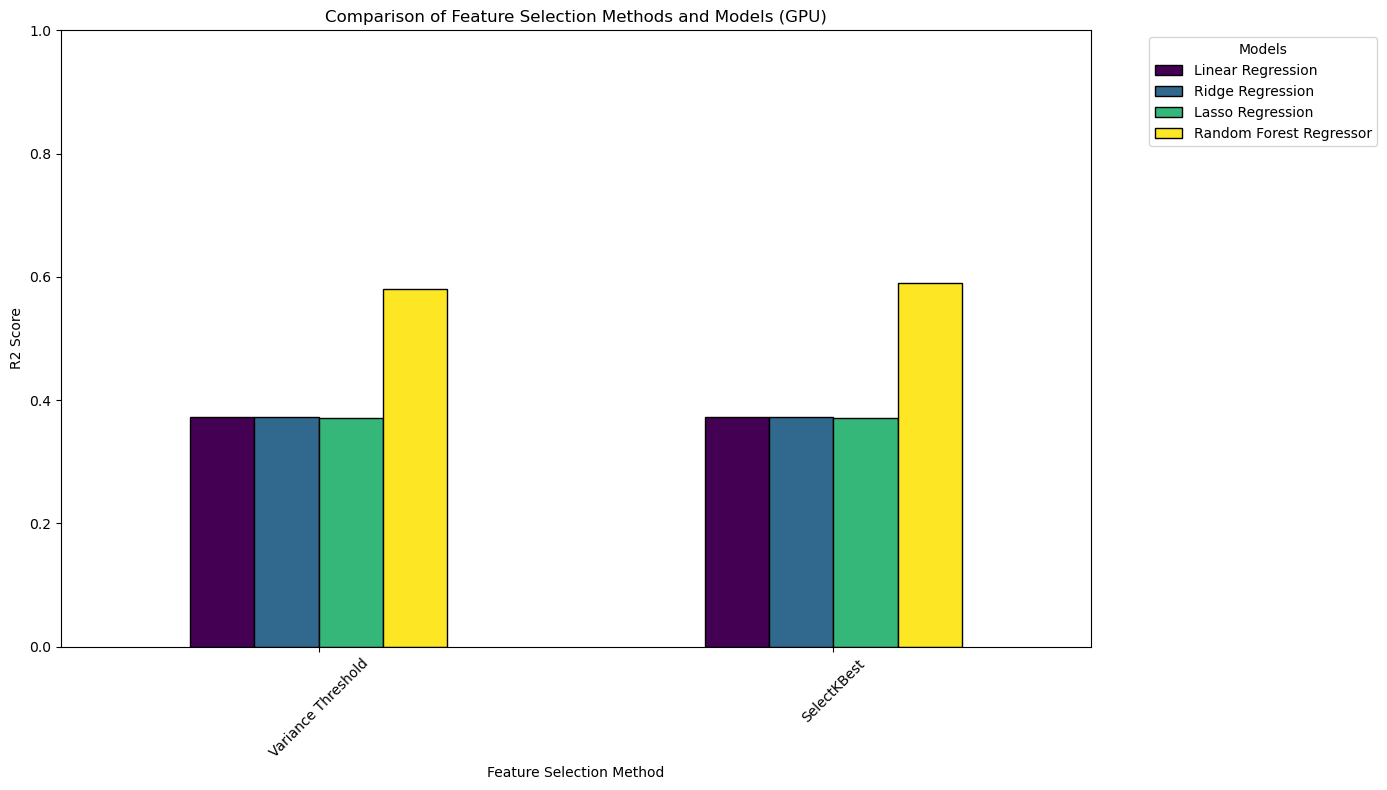

Comparison of Feature Selection Methods and Models (GPU):
                    Linear Regression  Ridge Regression  Lasso Regression  \
Variance Threshold           0.372427          0.372427          0.371326   
SelectKBest                  0.373024          0.373024          0.370630   

                    Random Forest Regressor  
Variance Threshold                 0.580996  
SelectKBest                        0.590626  


In [ ]:
import pandas as pd
import numpy as np
import cupy as cp
import cudf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, RFE
from sklearn.impute import SimpleImputer
from cuml.linear_model import LinearRegression, Ridge, Lasso
from cuml.ensemble import RandomForestRegressor
from cuml.metrics import r2_score
import matplotlib.pyplot as plt

# Example: Load Dataset
data = df.copy()  # Replace with your actual dataset
data = data.drop(['date'], axis=1)

# Drop rows where target variable (O₃) is missing
data.dropna(subset=['O_3'], inplace=True)

# Separate features and target
x = data.drop('O_3', axis=1)
y = data['O_3']

# Ensure all features are numeric
x = x.apply(pd.to_numeric, errors='coerce')

# Initial Imputation (using Scikit-learn's SimpleImputer)
imputer = SimpleImputer(strategy='mean')
x_imputed = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

# Convert to cuDF for GPU processing
x_imputed_cudf = cudf.DataFrame.from_pandas(x_imputed)
y_cudf = cudf.Series(y)

# Feature Selection Techniques (Scikit-learn)
methods = {
    "Variance Threshold": VarianceThreshold(threshold=0.01),  # Scikit-learn (CPU-based)
    "SelectKBest": SelectKBest(score_func=f_regression, k=10)  # Scikit-learn (CPU-based)
}

# Models for GPU
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50, random_state=42)
}

# Dictionary to store results
results = {method_name: {} for method_name in methods.keys()}

# Train and evaluate models for each feature selection method and model
for method_name, selector in methods.items():
    try:
        # Feature Selection
        if method_name == "Variance Threshold":
            x_selected = selector.fit_transform(x_imputed)
            selected_features = x.columns[selector.get_support()]
        else:
            x_selected = selector.fit_transform(x_imputed, y)
            selected_features = x.columns[selector.get_support()]
        
        x_selected_data = pd.DataFrame(x_selected, columns=selected_features)

        # Convert selected data to cuDF
        x_selected_data_cudf = cudf.DataFrame.from_pandas(x_selected_data)

        # Train-Test Split (GPU accelerated)
        x_train, x_test, y_train, y_test = train_test_split(x_selected_data_cudf, y_cudf, test_size=0.2, random_state=42)

        # Train and Evaluate Each Model
        for model_name, model in models.items():
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            r2_value = r2_score(y_test, y_pred)
            results[method_name][model_name] = float(r2_value)  # Convert to float for compatibility
    except Exception as e:
        print(f"Error in {method_name}: {e}")

# Convert results to DataFrame for Visualization
results_df = pd.DataFrame(results).T

# Plot Bar Chart for Comparison
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', figsize=(14, 8), colormap='viridis', edgecolor='black')
plt.xlabel('Feature Selection Method')
plt.ylabel('R2 Score')
plt.title('Comparison of Feature Selection Methods and Models (GPU)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print Results for Reference
print("Comparison of Feature Selection Methods and Models (GPU):")
print(results_df)


####Features

In [ ]:
print('Features:')
for i,j in enumerate(df.columns):
  print(i+1,'->',j)

Features:
1 -> date
2 -> BEN
3 -> CO
4 -> EBE
5 -> MXY
6 -> NMHC
7 -> NO_2
8 -> NOx
9 -> OXY
10 -> O_3
11 -> PM10
12 -> PXY
13 -> SO_2
14 -> TCH
15 -> TOL
16 -> station
17 -> PM25
18 -> NO
19 -> CH4


####First Five Value


In [ ]:
df.head()

,date,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
0,2001-08-01 01:00:00,NaN,0.37,NaN,NaN,NaN,58.400002,87.150002,NaN,34.529999,105.000000,NaN,6.34,NaN,NaN,28079001,NaN,NaN,NaN
1,2001-08-01 01:00:00,1.5,0.34,1.49,4.1,0.07,56.250000,75.169998,2.11,42.160000,100.599998,1.73,8.11,1.24,10.82,28079035,NaN,NaN,NaN
2,2001-08-01 01:00:00,NaN,0.28,NaN,NaN,NaN,50.660000,61.380001,NaN,46.310001,100.099998,NaN,7.85,NaN,NaN,28079003,NaN,NaN,NaN
3,2001-08-01 01:00:00,NaN,0.47,NaN,NaN,NaN,69.790001,73.449997,NaN,40.650002,69.779999,NaN,6.46,NaN,NaN,28079004,NaN,NaN,NaN
4,2001-08-01 01:00:00,NaN,0.39,NaN,NaN,NaN,22.830000,24.799999,NaN,66.309998,75.180000,NaN,8.80,NaN,NaN,28079039,NaN,NaN,NaN


####Last Five Values

In [ ]:
df.tail()

,date,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
3598723,2018-02-01 00:00:00,NaN,0.5,NaN,NaN,NaN,91.0,192.0,NaN,1.0,35.0,NaN,NaN,NaN,NaN,28079056,22.0,66.0,NaN
3598724,2018-02-01 00:00:00,NaN,0.7,NaN,NaN,NaN,107.0,241.0,NaN,NaN,29.0,NaN,15.0,NaN,NaN,28079057,NaN,87.0,NaN
3598725,2018-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,48.0,91.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,28079058,NaN,28.0,NaN
3598726,2018-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,103.0,320.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,28079059,NaN,141.0,NaN
3598727,2018-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,96.0,202.0,NaN,3.0,26.0,NaN,NaN,NaN,NaN,28079060,NaN,69.0,NaN


####Description Of Dataset

In [ ]:
#shape
print('Shape:(row,col)')
print(df.shape)
print('***'*10)
#information of the datas
print('Information:')
print(df.info())
print('***'*10)


Shape:(row,col)
(3598728, 19)
******************************
Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598728 entries, 0 to 3598727
Data columns (total 19 columns):
 #   Column   Dtype  
---  ------   -----  
 0   date     object 
 1   BEN      float64
 2   CO       float64
 3   EBE      float64
 4   MXY      float64
 5   NMHC     float64
 6   NO_2     float64
 7   NOx      float64
 8   OXY      float64
 9   O_3      float64
 10  PM10     float64
 11  PXY      float64
 12  SO_2     float64
 13  TCH      float64
 14  TOL      float64
 15  station  int64  
 16  PM25     float64
 17  NO       float64
 18  CH4      float64
dtypes: float64(17), int64(1), object(1)
memory usage: 521.7+ MB
None
******************************


#Visualizing Data

####Dsecription of the Data

In [ ]:
#descriptive statistics (numerical) #exploratory data analysis
print(df.describe().T)

             count          mean         std          min          25%  \
BEN       990929.0  1.289442e+00    1.944129         0.00         0.23   
CO       2565013.0  5.569361e-01    0.541429         0.00         0.27   
EBE       951389.0  1.462607e+00    2.182929         0.00         0.40   
MXY       315415.0  4.650394e+00    5.599223         0.00         1.20   
NMHC     1059342.0  1.889321e-01    0.154417         0.00         0.09   
NO_2     3578436.0  5.116596e+01   34.724916         0.00        24.52   
NOx      2376275.0  1.093188e+02  110.287083         0.00        40.00   
OXY       315695.0  2.280912e+00    2.639609         0.00         0.96   
O_3      2870535.0  3.943581e+01   30.172747         0.00        12.51   
PM10     2758363.0  2.930154e+01   26.079254         0.00        11.78   
PXY       315584.0  2.056178e+00    2.395130         0.00         0.80   
SO_2     2689937.0  1.075018e+01    9.200431         0.00         5.91   
TCH      1060471.0  1.437466e+00    0.

###Histogram to understand the distribution

                       date
count               3598728
unique               143112
top     2003-07-21 13:00:00
freq                     28


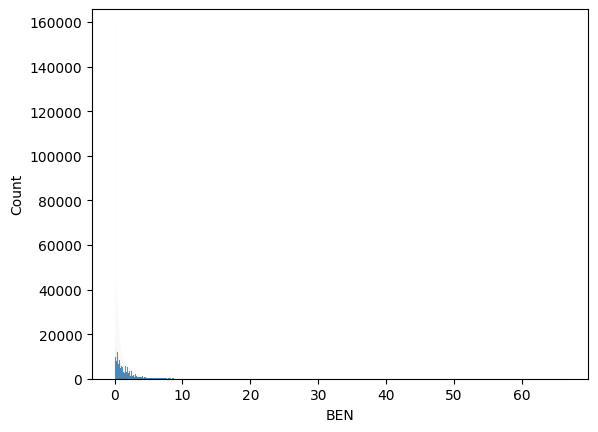

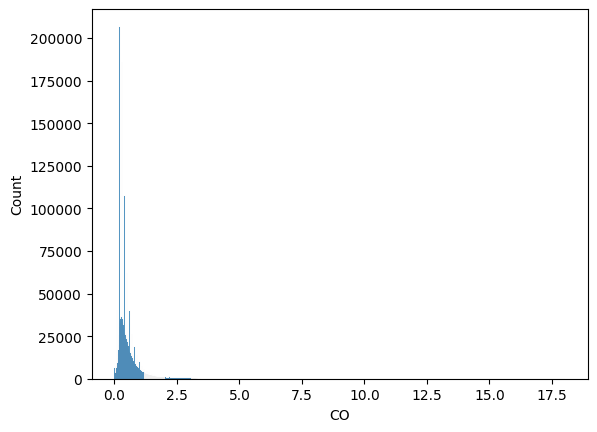

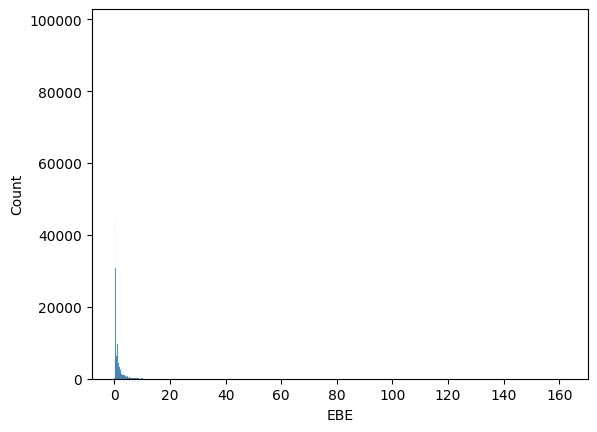

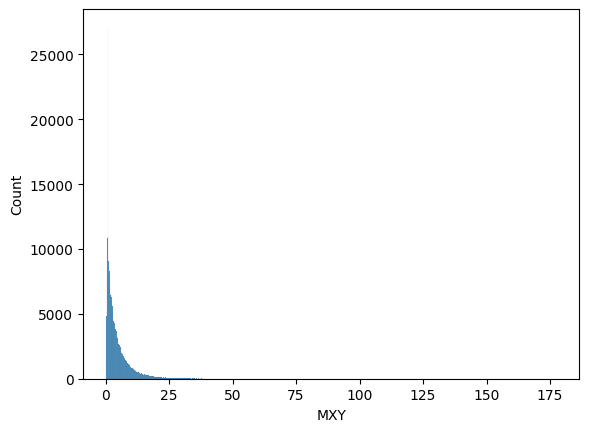

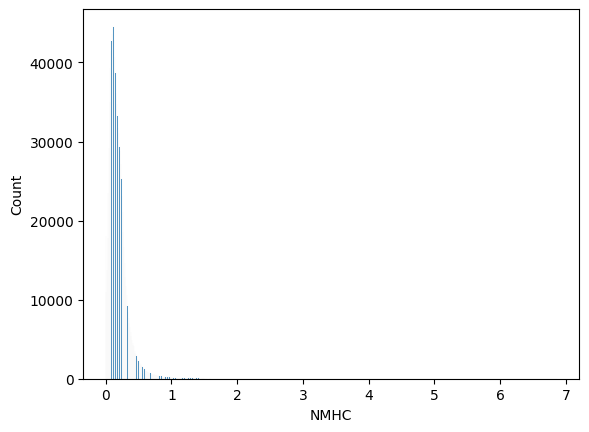

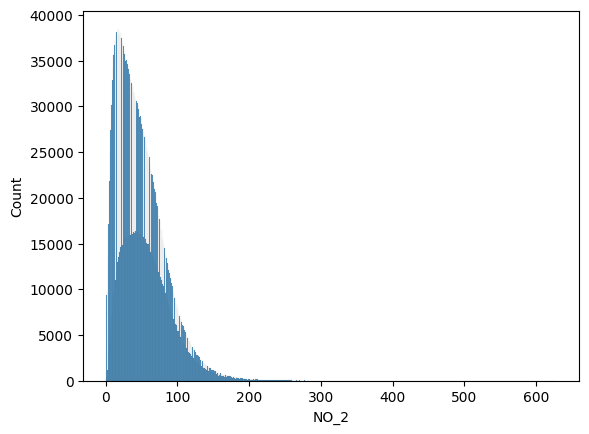

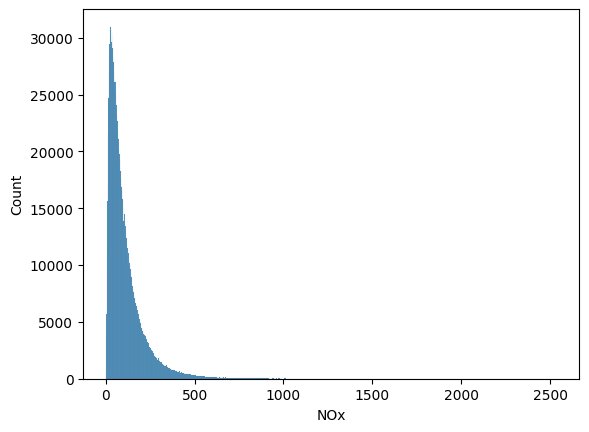

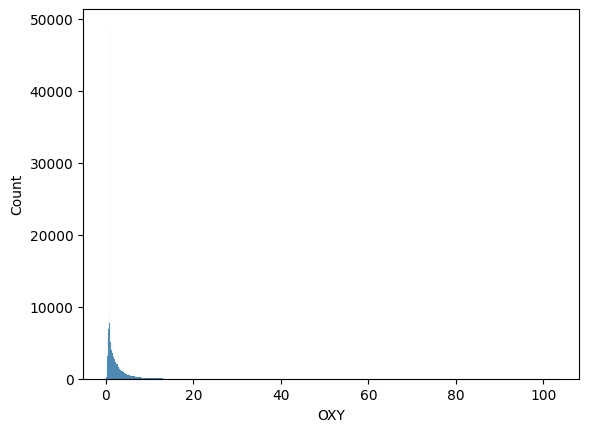

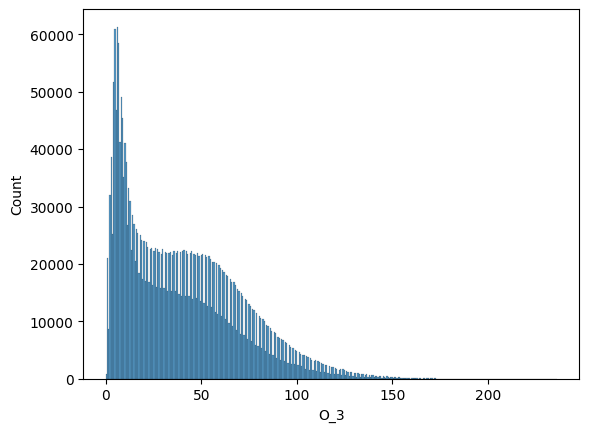

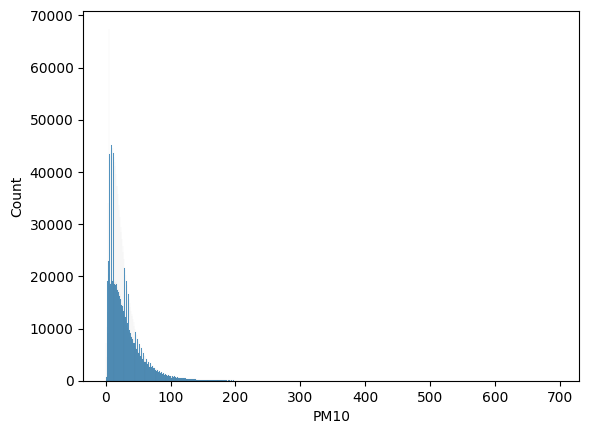

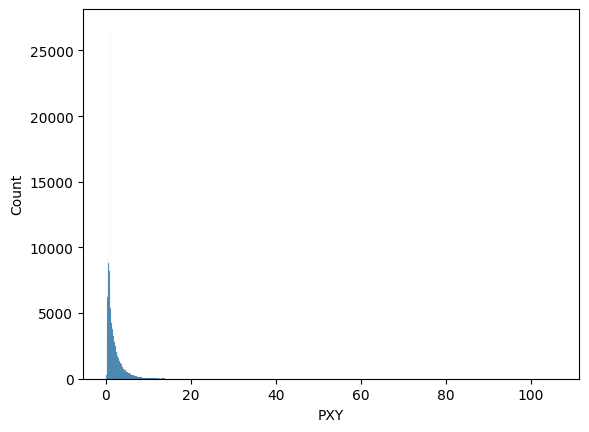

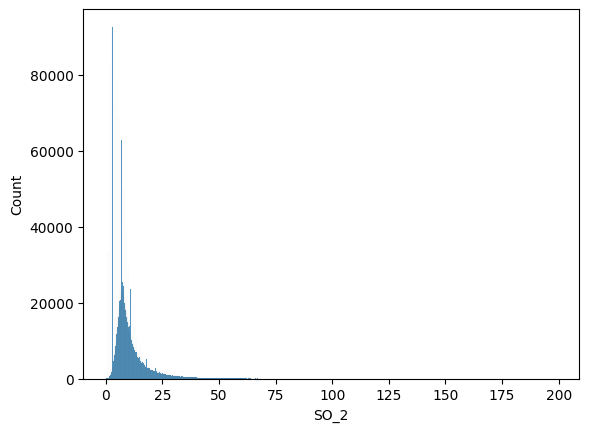

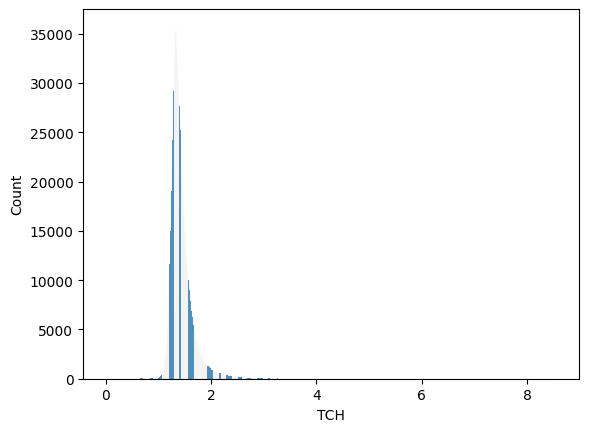

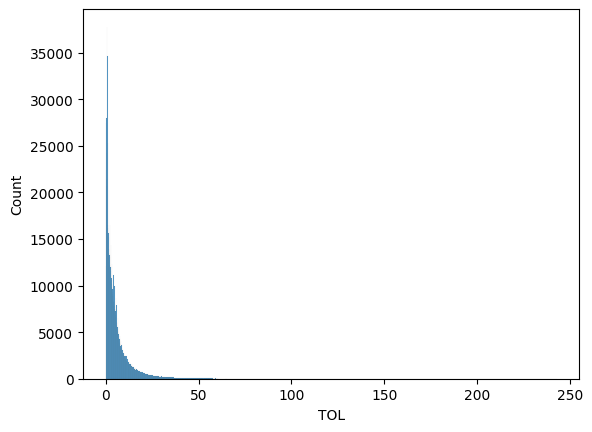

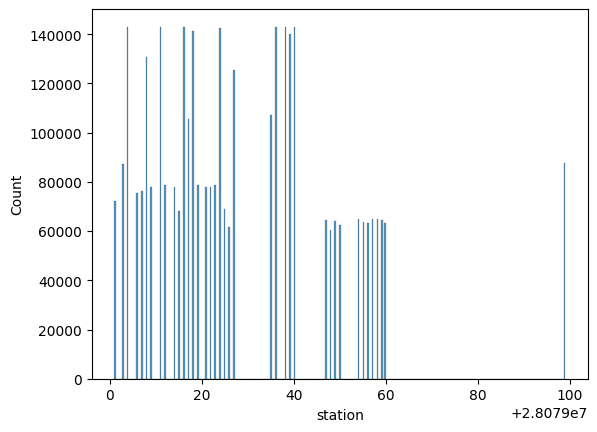

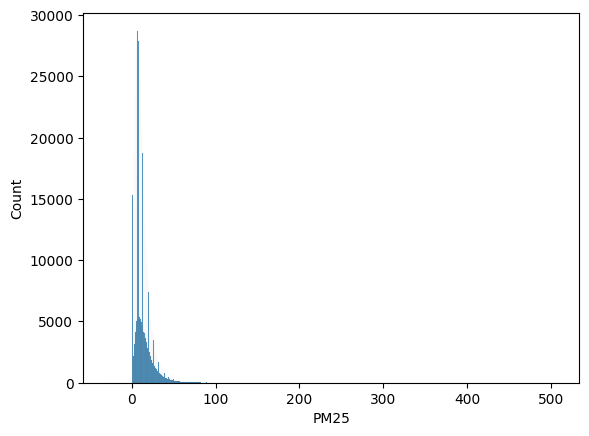

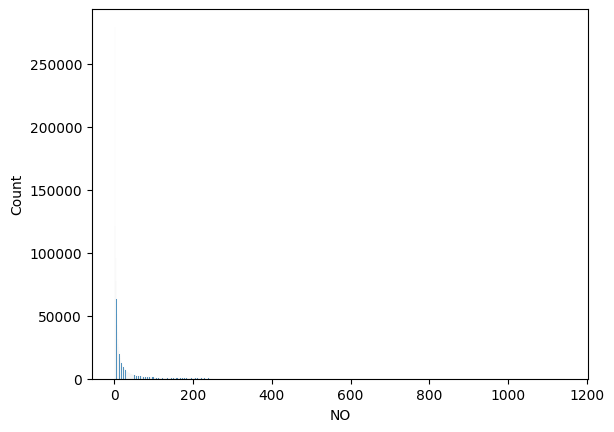

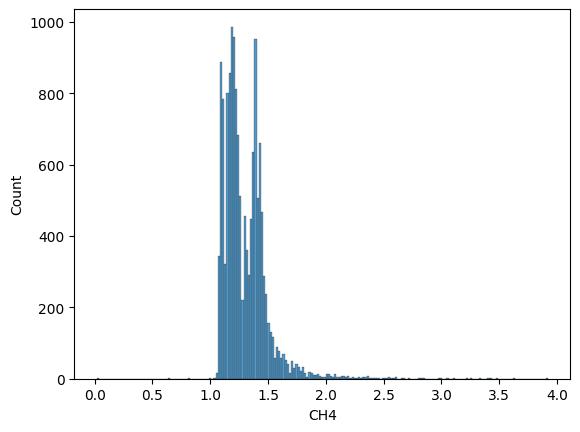

In [ ]:
#step 4 exploratory Data Analysis (EDA)

#object value
print(df.describe(include='object'))
#histogram to understand the distribution
for i in df.select_dtypes(include="number").columns:
  sns.histplot(data=df,x=i)
  plt.show()

####KDE Plot for better understaning of Distribution

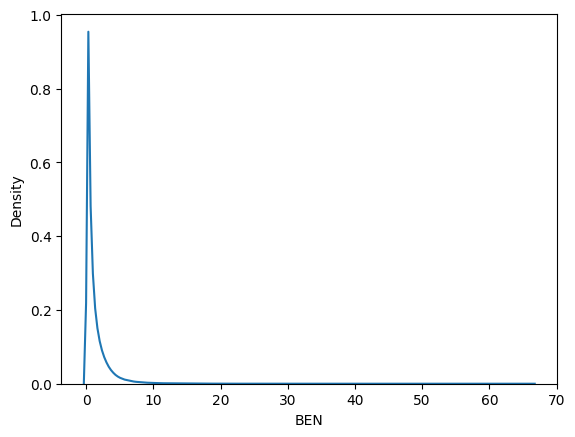

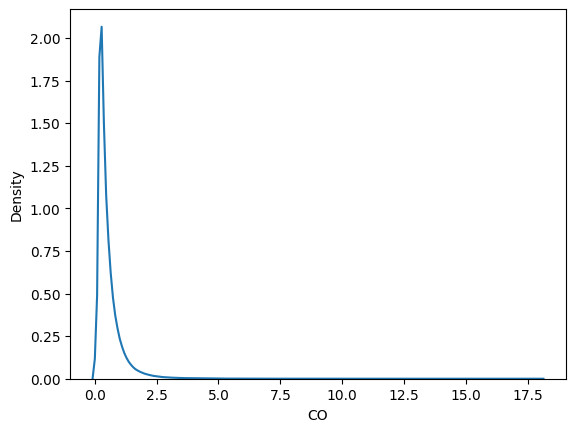

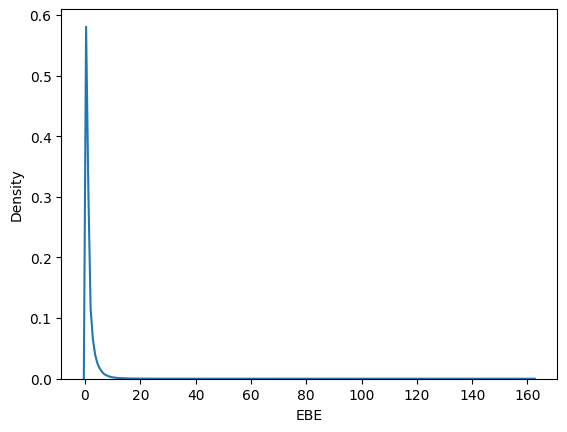

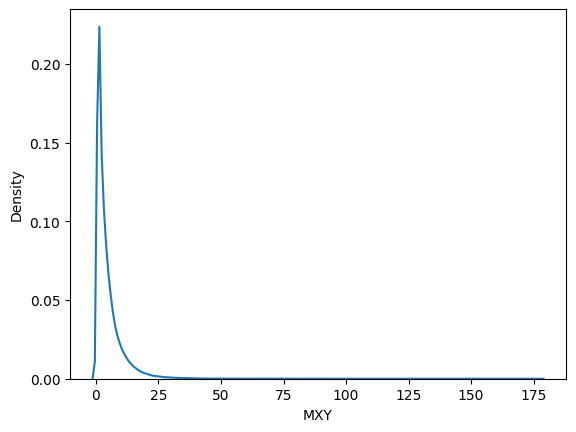

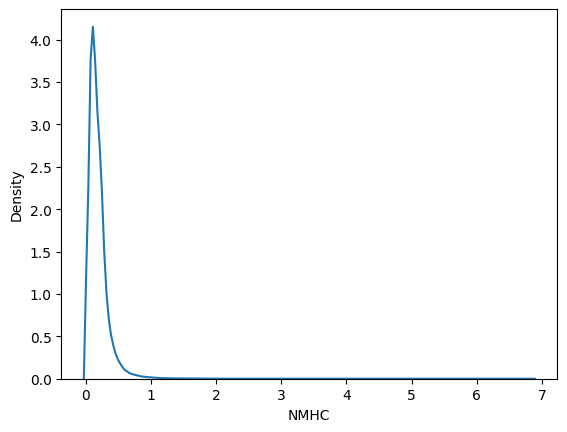

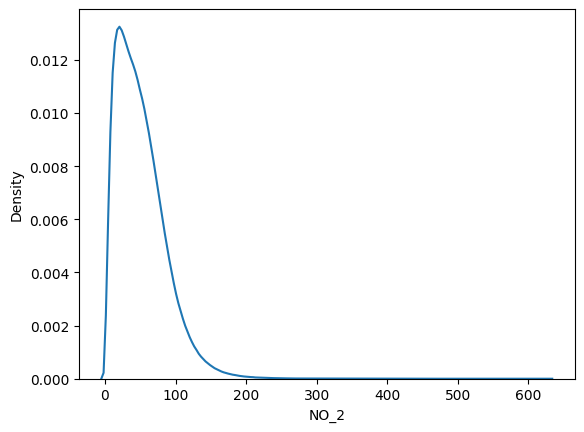

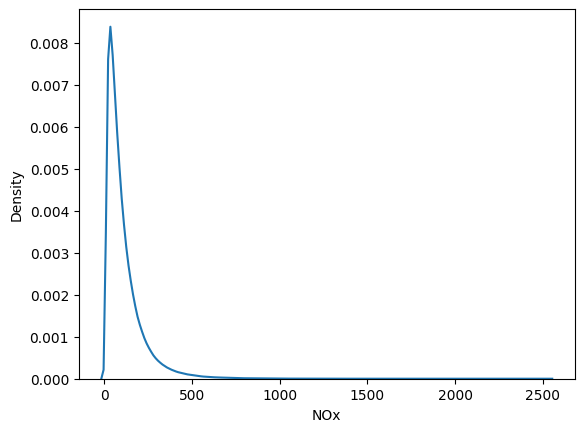

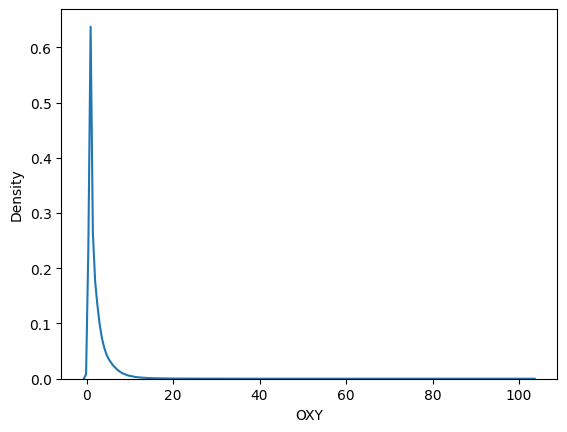

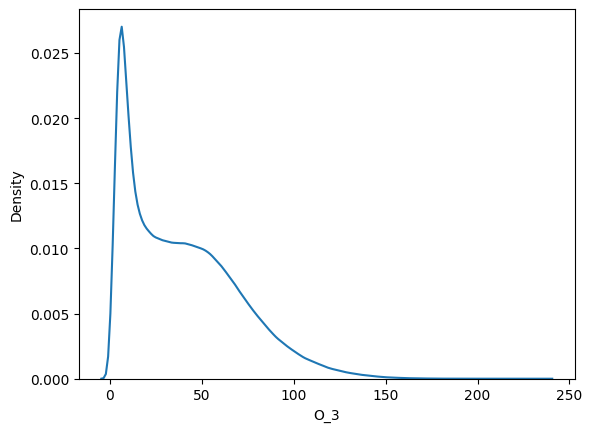

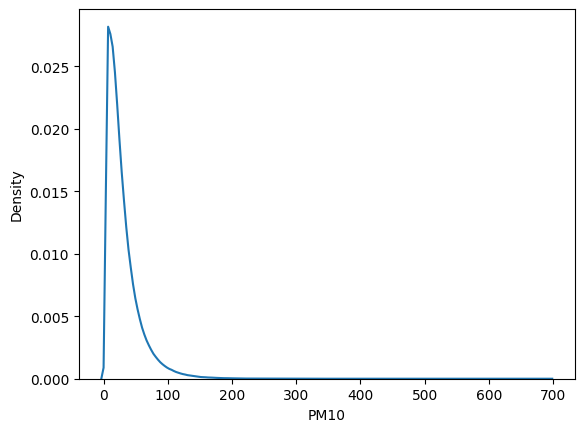

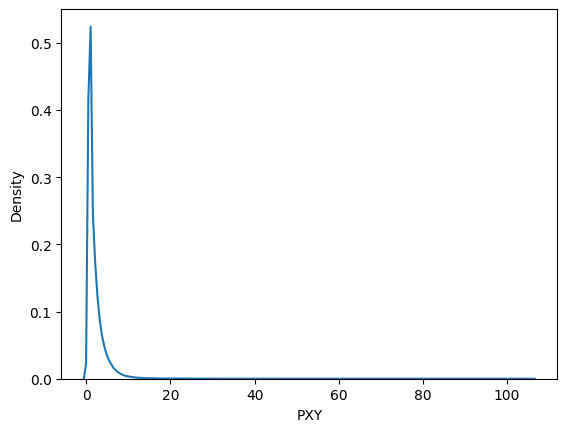

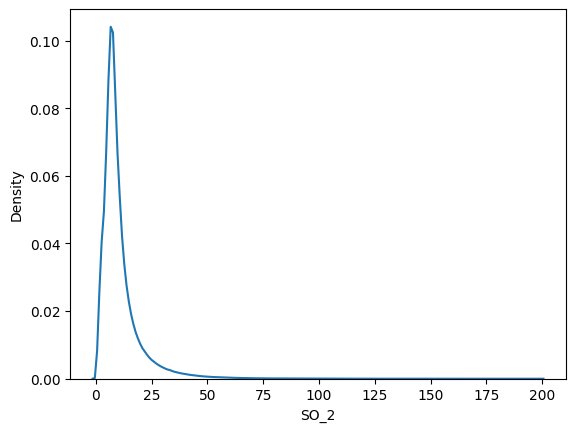

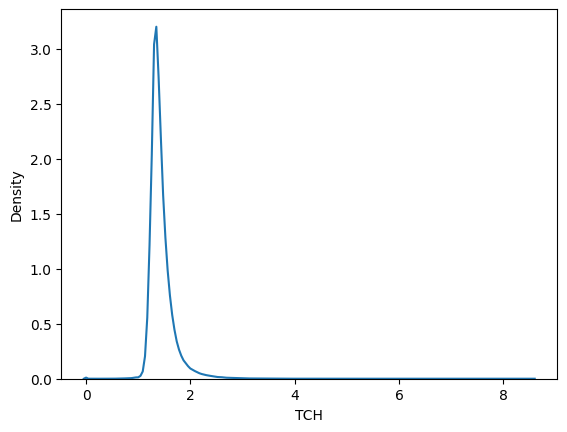

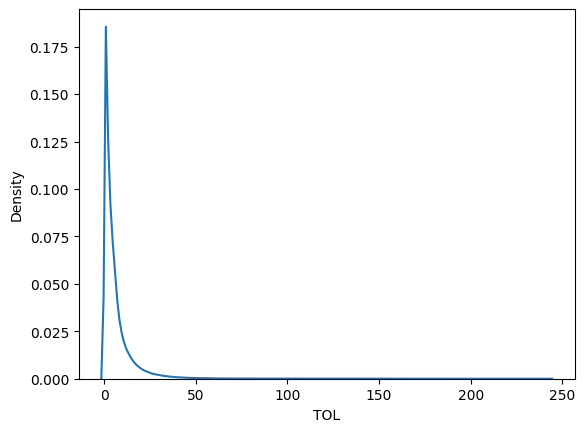

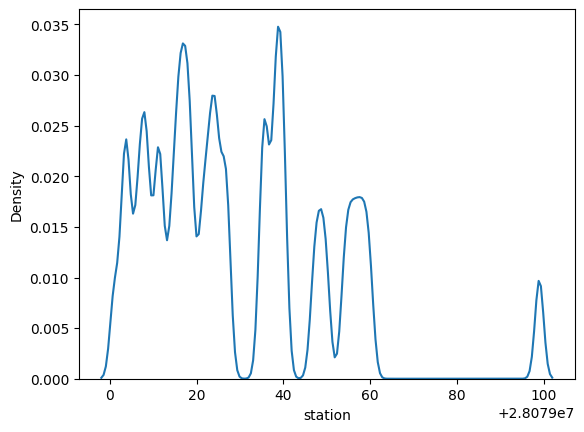

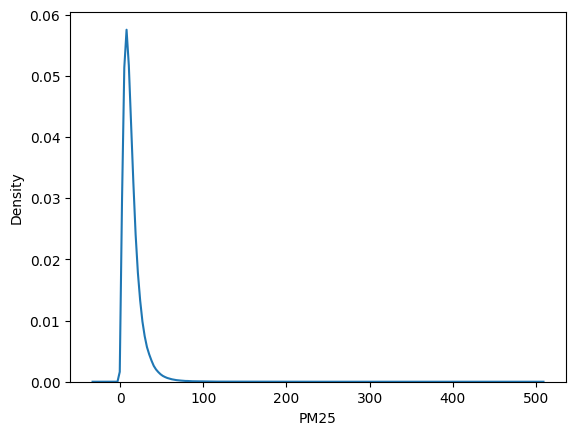

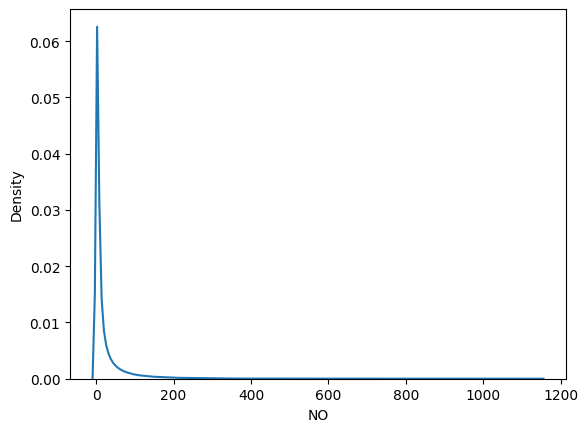

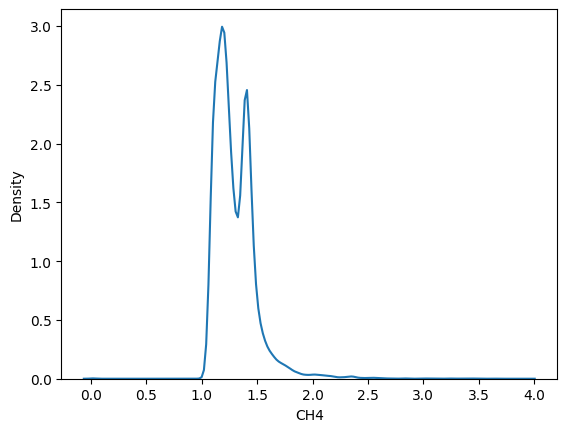

In [ ]:
for i in df.select_dtypes(include=['number', 'datetime']).columns:
  sns.kdeplot(data=df, x=i)
  plt.show()

####Scatter plot to understanf the relationship

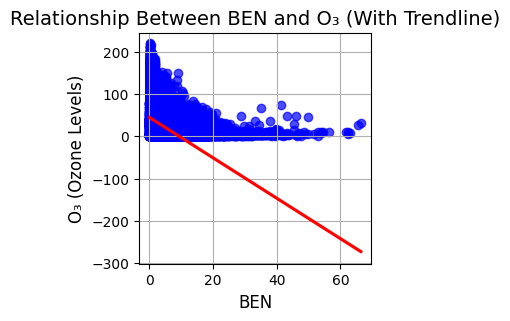

KeyboardInterrupt: 

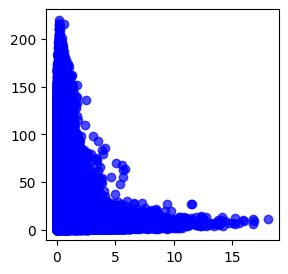

In [ ]:
# # #scatter plot understand the relationship
## List of features to analyze


features = ['BEN', 'CO', 'EBE', 'MXY', 'NMHC', 'NO_2', 'NOx', 'OXY',
       'PM10', 'PXY', 'SO_2', 'TCH', 'TOL', 'station','PM25']

for feature in features:
        plt.figure(figsize=(3, 3))
        sns.regplot(
            data=df,
            x=feature,
            y='O_3',
            scatter_kws={'alpha': 0.7, 'color': 'blue'},
            line_kws={'color': 'red'}
        )
        plt.title(f'Relationship Between {feature} and O₃ (With Trendline)', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('O₃ (Ozone Levels)', fontsize=12)
        plt.grid(True)
        plt.show()


####Correlation with heatmap to intrepret the relation and multicollinarity

<Axes: >

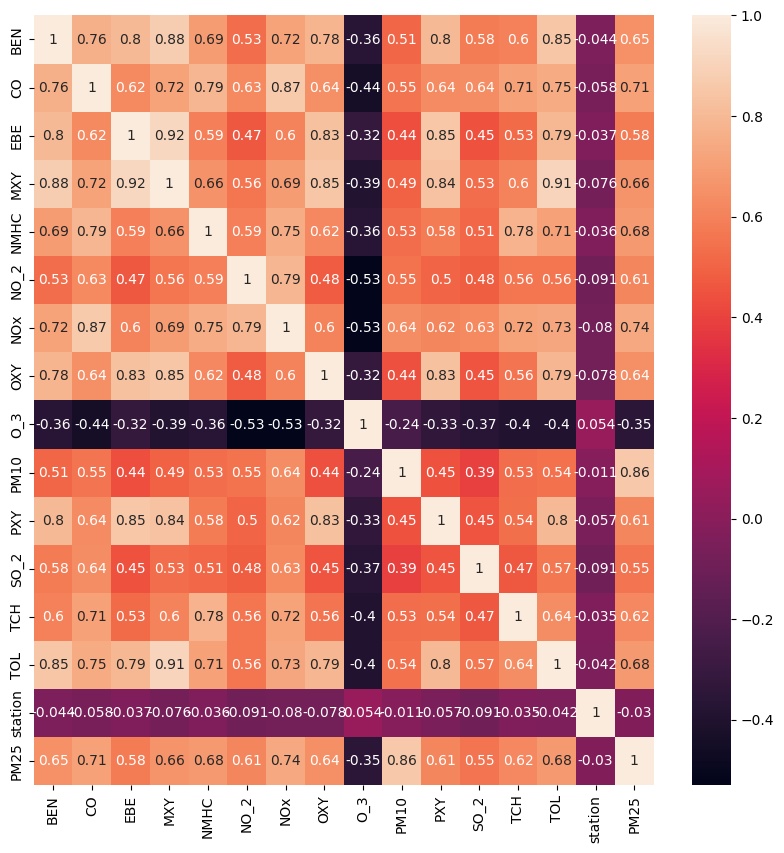

In [ ]:
# correlation with heatmap to intrepret the relation and multicollinarity
df.select_dtypes(include='number').corr()
plt.figure(figsize=(10,10))
sns.heatmap(df.select_dtypes(include='number').corr(),annot=True)


###Finding the outliers of the dataset using BoxPlot

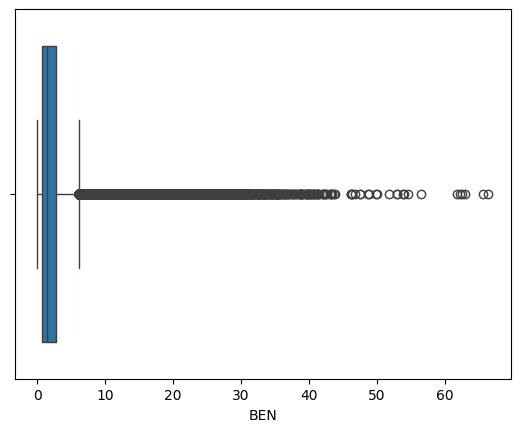

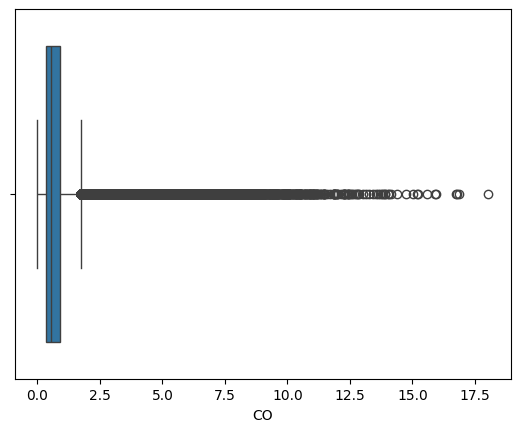

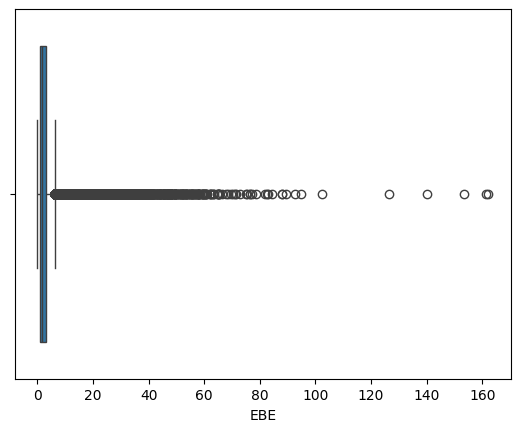

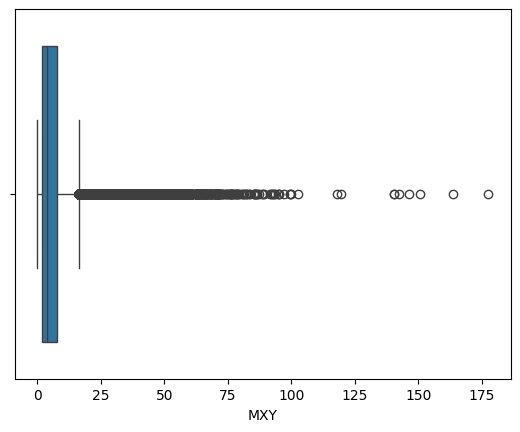

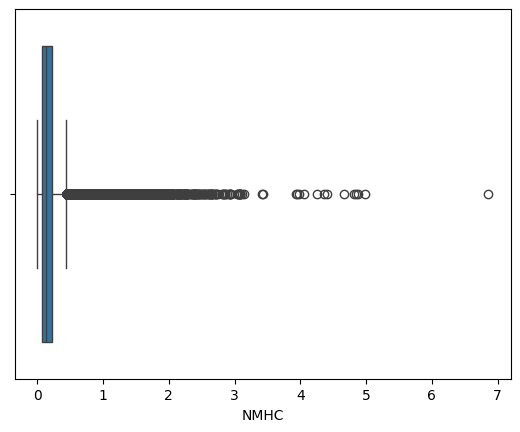

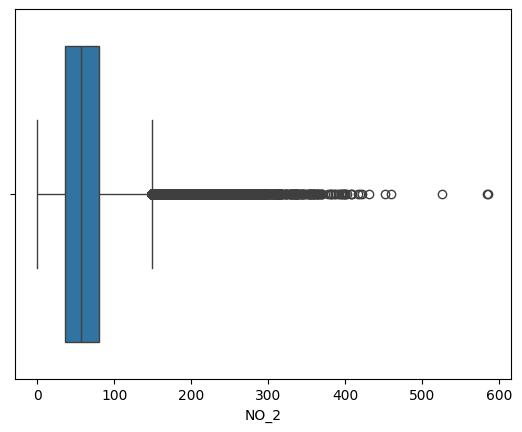

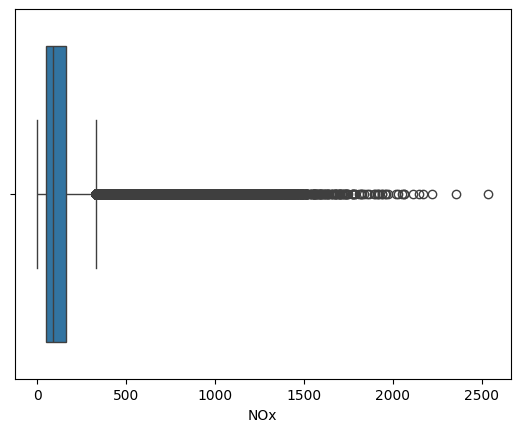

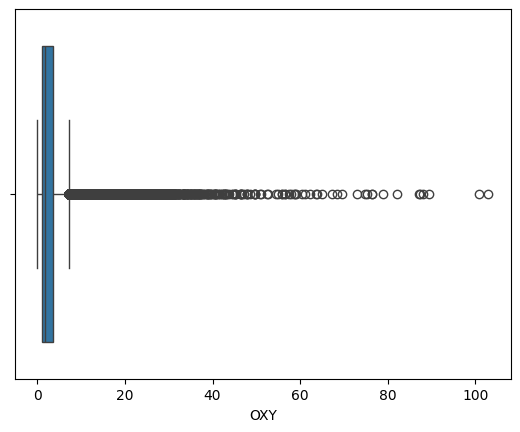

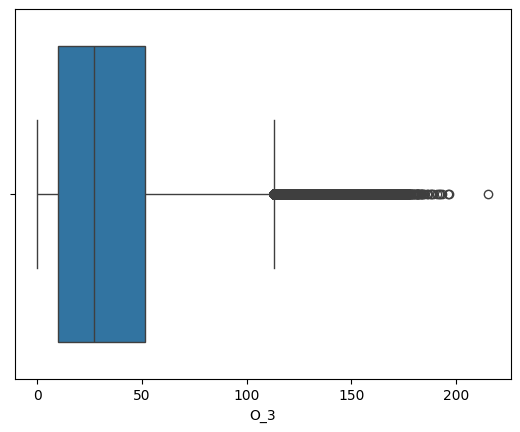

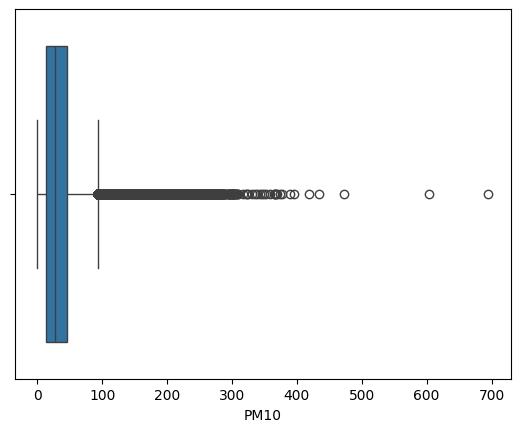

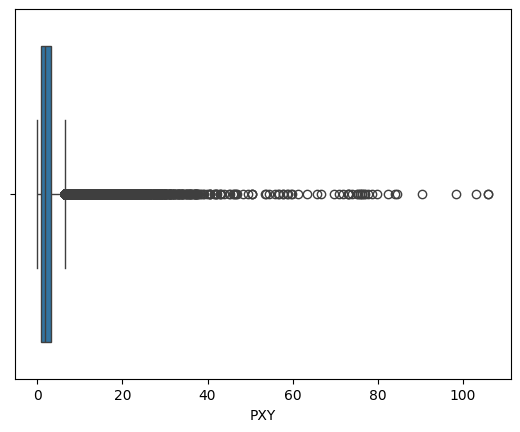

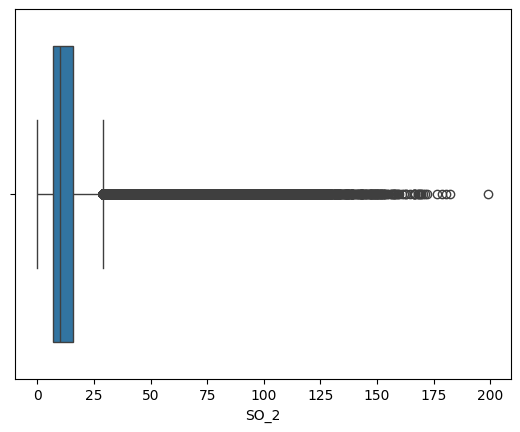

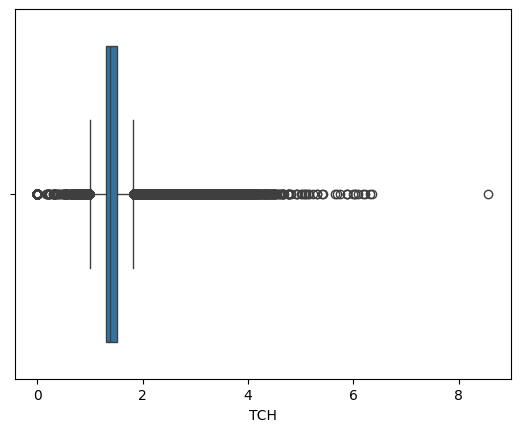

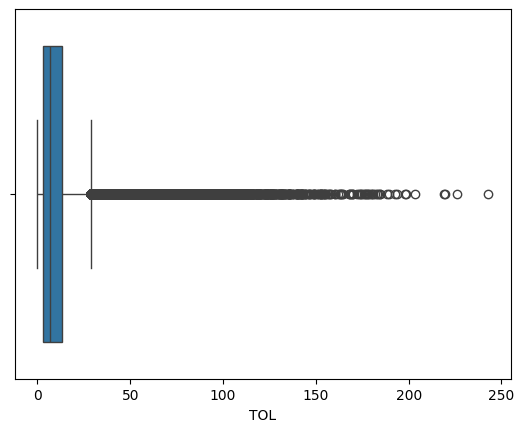

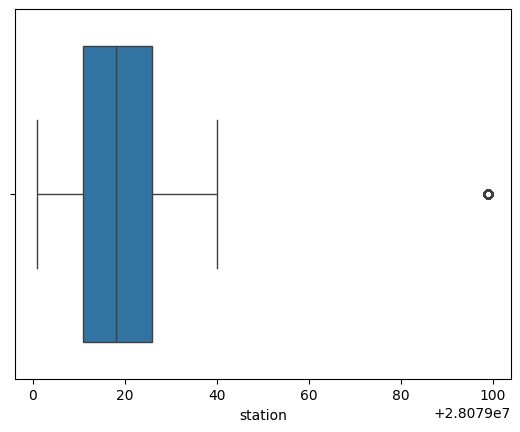

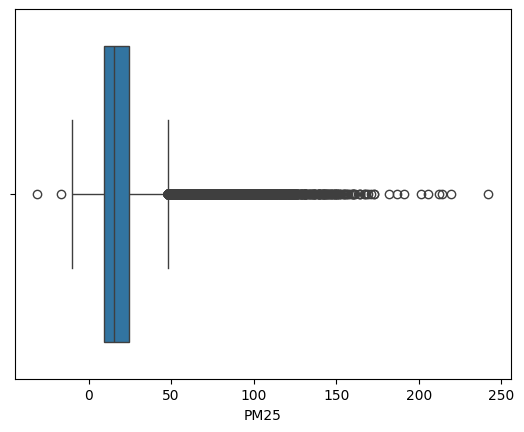

In [ ]:
#box plot to understand the outliers
for i in df.select_dtypes(include="number").columns:
  sns.boxplot(data=df,x=i)
  plt.show()

#Data Cleaning

In [ ]:
#finding missing value
print('Missing Value:')
print(df.isnull().sum())
print('***'*10)
#finding percantage of missing value
print('Percentage of Missing Value:')
print(df.isnull().sum()/df.shape[0]*100)
print('***'*10)
#finding duplicates
print('Duplicates:')
print(df.duplicated().sum())
print('***'*10)
#idenfying garbage value
print('Garbage Value:')
for i in df.select_dtypes(include='object').columns: #cz garbage are in object type value
   print(df[i].value_counts())
   print('***'*10)
# no garbage value as it would show in the last and show the character and the count also


Missing Value:
date             0
BEN        2607799
CO         1033715
EBE        2647339
MXY        3283313
NMHC       2539386
NO_2         20292
NOx        1222453
OXY        3283033
O_3         728193
PM10        840365
PXY        3283144
SO_2        908791
TCH        2538257
TOL        2610461
station          0
PM25       2834469
NO         2274945
CH4        3583878
dtype: int64
******************************
Percentage of Missing Value:
date        0.000000
BEN        72.464465
CO         28.724455
EBE        73.563187
MXY        91.235375
NMHC       70.563432
NO_2        0.563866
NOx        33.969030
OXY        91.227595
O_3        20.234733
PM10       23.351723
PXY        91.230679
SO_2       25.253117
TCH        70.532060
TOL        72.538436
station     0.000000
PM25       78.763080
NO         63.215253
CH4        99.587354
dtype: float64
******************************
Duplicates:
0
******************************
Garbage Value:
date
2003-07-21 13:00:00    28
2003-06-15 03:0

###dropping these features since the missing values percentage is greater than 50% and there are no duplicate value and Garbage values in the dataset


In [5]:
df=df.drop(['BEN', 'EBE','MXY', 'NMHC','TCH','OXY','PXY','TOL','station','date','PM25','CH4','NOx','NO'], axis = 1)
df.head()
#[Dropping station as it is irrelevant for our analysis]

,CO,NO_2,O_3,PM10,SO_2
0,0.37,58.400002,34.529999,105.000000,6.34
1,0.34,56.250000,42.160000,100.599998,8.11
2,0.28,50.660000,46.310001,100.099998,7.85
3,0.47,69.790001,40.650002,69.779999,6.46
4,0.39,22.830000,66.309998,75.180000,8.80


###Cleaning datas where target value (O_3) is Null

In [6]:
df= df.dropna(subset=['O_3'])
print('New Shape after dropping null rows of target value:')
df.shape

New Shape after dropping null rows of target value:


(2991732, 5)

###Imputing other NULL values using Median


In [7]:
df['CO'].fillna(df['CO'].mean(), inplace = True)
df['NO_2'].fillna(df['NO_2'].mean(), inplace = True)
df['PM10'].fillna(df['PM10'].mean(), inplace = True)
df['SO_2'].fillna(df['SO_2'].mean(), inplace = True)

In [8]:
print('Result After imputing:\n',df.isnull().sum())

Result After imputing:
 CO      0
NO_2    0
O_3     0
PM10    0
SO_2    0
dtype: int64


### Caluculating wisker to treat outliers

In [9]:
#Outlier treatment
#outlier is the extreme value whether in the upper side or lower side
def wisker(col):
  q1,q3=np.percentile(col,[25,75])
  iqr=q3-q1 #inter-quartile range
  lower_bound=q1-(1.5*iqr)
  upper_bound=q3+(1.5*iqr)
  return lower_bound,upper_bound


df.columns

Index(['CO', 'NO_2', 'O_3', 'PM10', 'SO_2'], dtype='object')

###Treating those values which have outliers

In [10]:
for i in ['CO','NO_2','PM10','SO_2']:
  lw,uk=wisker(df[i])
  df[i]=np.where(df[i]>uk,uk,df[i])
  df[i]=np.where(df[i]<lw,lw,df[i])

###Checking if outliers are fixed or not

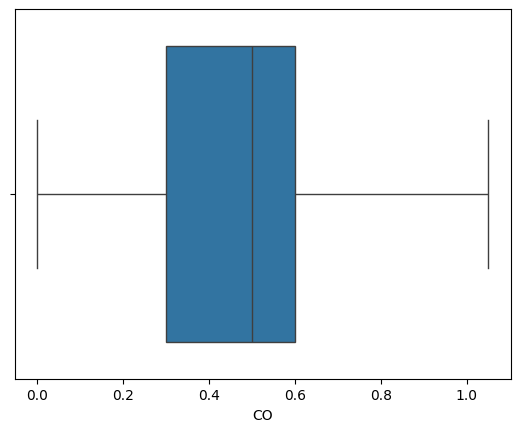

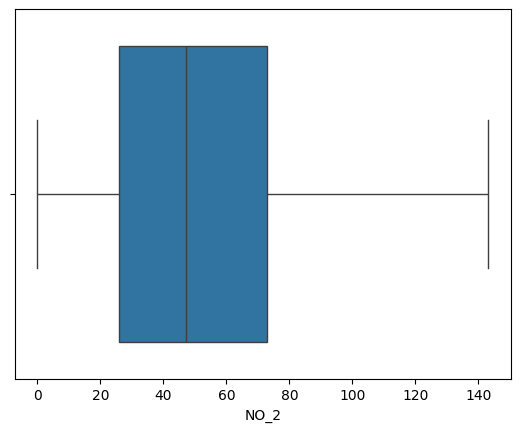

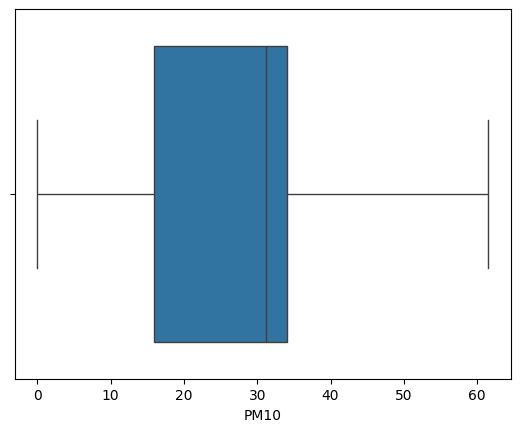

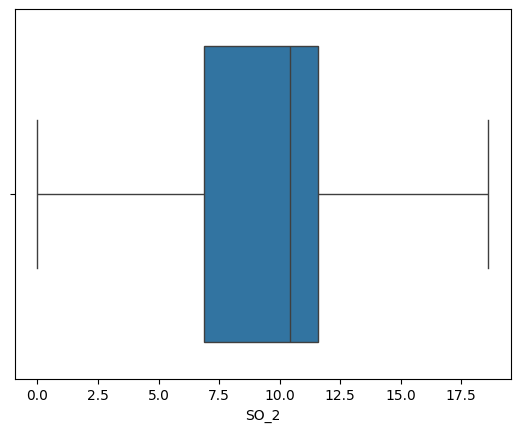

In [ ]:
for i in ['CO','NO_2','PM10','SO_2']:
  sns.boxplot(data=df,x=i)
  plt.show()

####Data Before Cleaning Vs Data After Cleaning

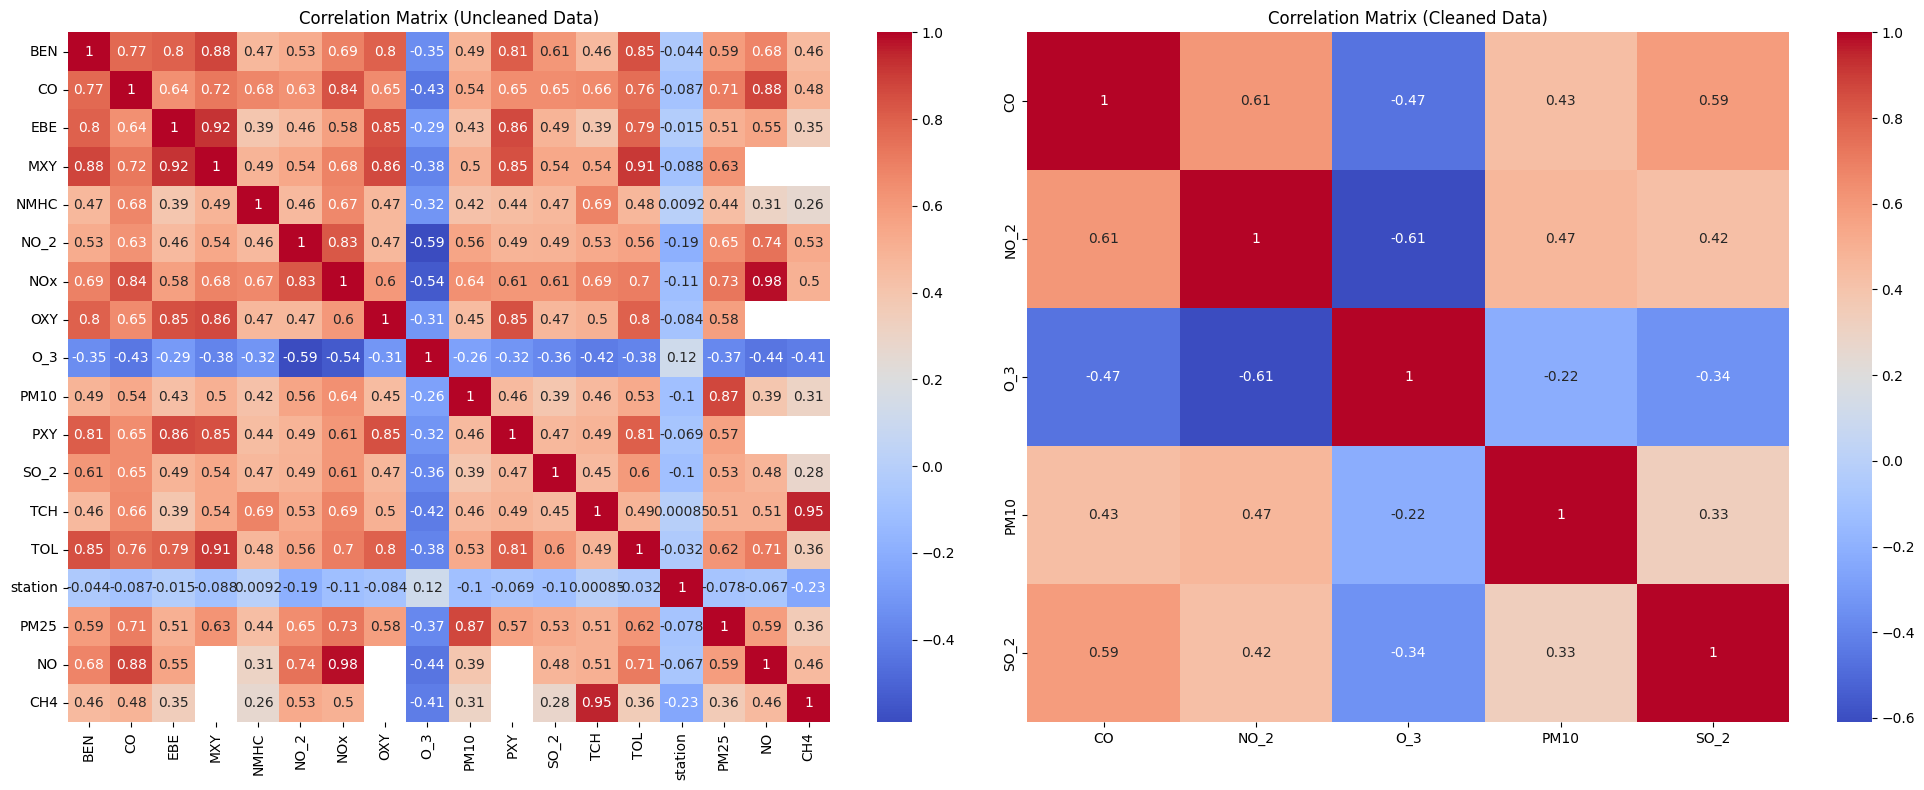

In [ ]:

# Calculate correlation for uncleaned data
corr_uncleaned = df_init.select_dtypes(include='number').corr()

# Calculate correlation for cleaned data
corr_cleaned = df.select_dtypes(include='number').corr()

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap for uncleaned data
sns.heatmap(corr_uncleaned, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix (Uncleaned Data)')

# Heatmap for cleaned data
sns.heatmap(corr_cleaned, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix (Cleaned Data)')

plt.tight_layout()
plt.show()

###Scalling the Data

In [11]:
scaler=MinMaxScaler()
df_scaled=scaler.fit_transform(df)
df_scaled=pd.DataFrame(df_scaled,columns=df.columns)
print('Data Before Scalling:')
print(df.head())
print('Data After Scaling:')
print(df_scaled.head())

Data Before Scalling:
     CO       NO_2        O_3       PM10  SO_2
0  0.37  58.400002  34.529999  59.100004  6.34
1  0.34  56.250000  42.160000  59.100004  8.11
2  0.28  50.660000  46.310001  59.100004  7.85
3  0.47  69.790001  40.650002  59.100004  6.46
4  0.39  22.830000  66.309998  59.100004  8.80
Data After Scaling:
         CO      NO_2       O_3  PM10      SO_2
0  0.360976  0.411253  0.146314   1.0  0.341443
1  0.331707  0.396113  0.178644   1.0  0.440436
2  0.273171  0.356748  0.196229   1.0  0.425895
3  0.458537  0.491462  0.172246   1.0  0.348154
4  0.380488  0.160769  0.280975   1.0  0.479027


###Splitting Datset

In [12]:
x=df_scaled.drop('O_3',axis=1)
y=df_scaled['O_3']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

df_scaled.tail()

,CO,NO_2,O_3,PM10,SO_2
2991727,0.554787,1.000000,0.008475,0.525141,0.623068
2991728,0.487805,0.640823,0.004237,0.592217,0.623068
2991729,0.554787,0.338016,0.008475,0.525141,0.623068
2991730,0.554787,0.725327,0.008475,0.525141,0.623068
2991731,0.554787,0.676033,0.012712,0.439932,0.623068


#Model Train

### 1. Linear Regression

In [13]:

x=df_scaled.drop('O_3',axis=1)
y=df_scaled['O_3']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
model1=LinearRegression()
model1.fit(x_train,y_train)

LinearRegression()

In [14]:
y_predict=model1.predict(x_test)

                        MSE      RMSE       MAE        R2  \
 Linear Regression  0.00988  0.099399  0.076899  0.401882   

                    Explained Variance Score:  
 Linear Regression                   0.401883  
-0.017828918356738617


<Axes: xlabel='O_3', ylabel='Density'>

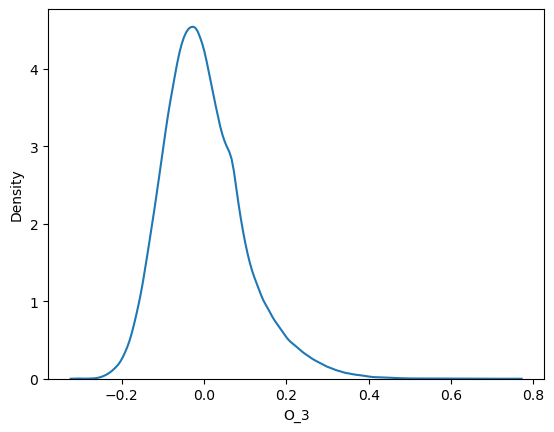

In [15]:
l_mse = mean_squared_error(y_test,y_predict)
l_rmse = np.sqrt(l_mse)
l_mae = mean_absolute_error(y_test,y_predict)
l_r2 = r2_score(y_test,y_predict)
l_explained_variance = explained_variance_score(y_test,y_predict)
print(pd.DataFrame({'MSE':l_mse,'RMSE':l_rmse,'MAE':l_mae,'R2':l_r2,'Explained Variance Score:':l_explained_variance},index=[' Linear Regression']))

residue=y_test-y_predict
residue.mean()
print(residue.mean()*100)
sns.kdeplot(x=residue)

Best Hyperparameters: {'fit_intercept': True, 'positive': False}
                             MSE      RMSE       MAE        R2  \
Tuned Linear Regression  0.00988  0.099399  0.076899  0.401882   

                         Explained Variance Score:  
Tuned Linear Regression                   0.401883  
Mean of residue: -0.00017828918356738616


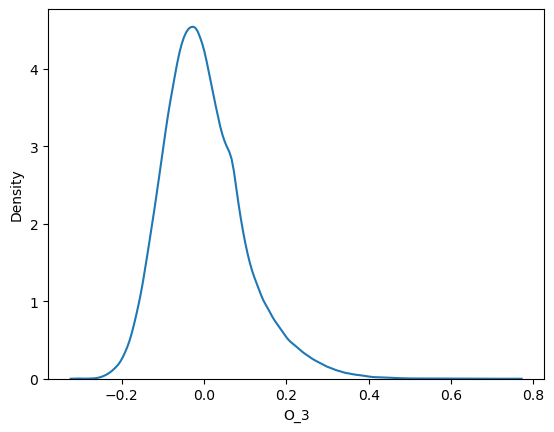

In [16]:



# Define the parameter grid for hyperparameter tuning
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, cv=6, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test data
y_pred = best_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print(pd.DataFrame({'MSE':mse,'RMSE':rmse,'MAE':mae,'R2':r2,'Explained Variance Score:':explained_variance},index=['Tuned Linear Regression']))

residue = y_test - y_pred
print("Mean of residue:", residue.mean())
sns.kdeplot(x=residue)
plt.show()

/home/abir_hossain/miniconda3/envs/P2/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=1000. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters (RandomizedSearchCV): {'positive': False, 'fit_intercept': True}
                                                  MSE      RMSE       MAE  \
Tuned Linear Regression (RandomizedSearchCV)  0.00988  0.099399  0.076899   

                                                    R2  \
Tuned Linear Regression (RandomizedSearchCV)  0.401882   

                                              Explained Variance Score:  
Tuned Linear Regression (RandomizedSearchCV)                   0.401883  
Mean of residue (RandomizedSearchCV): -0.00017828918356738616


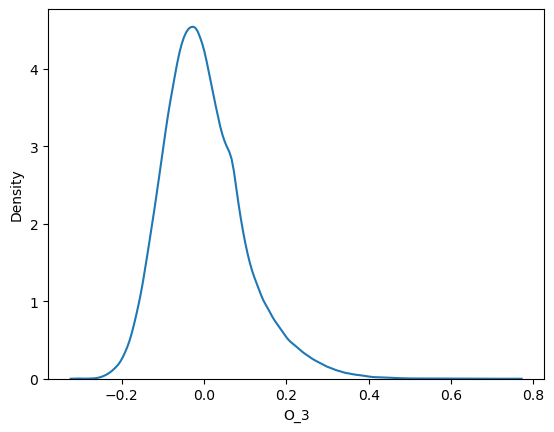

In [17]:

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model1, param_distributions=param_dist, n_iter=1000, cv=7, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)

# Evaluate the best model on the test data
y_pred_random = best_model_random.predict(x_test)
mse_random = mean_squared_error(y_test, y_pred_random)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)
explained_variance_random = explained_variance_score(y_test, y_pred_random)

print(pd.DataFrame({'MSE':mse_random,'RMSE':rmse_random,'MAE':mae_random,'R2':r2_random,'Explained Variance Score:':explained_variance_random},index=['Tuned Linear Regression (RandomizedSearchCV)']))

residue_random = y_test - y_pred_random
print("Mean of residue (RandomizedSearchCV):", residue_random.mean())
sns.kdeplot(x=residue_random)
plt.show()

In [ ]:

# model_gb = GradientBoostingRegressor()

# param_grid_gb = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 1],
#     'max_depth': [3, 5, 7]
# }
# grid_search_gb = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # Changed the estimator to model_gb
# grid_search_gb.fit(x_train, y_train)

# best_params_gb = grid_search_gb.best_params_
# best_model_gb = grid_search_gb.best_estimator_

# print("Best Hyperparameters (Gradient Boosting - GridSearchCV):", best_params_gb)

# y_pred_gb_tuned = best_model_gb.predict(x_test)
# gb_mse_tuned = mean_squared_error(y_test, y_pred_gb_tuned)
# gb_rmse_tuned = np.sqrt(gb_mse_tuned)
# gb_mae_tuned = mean_absolute_error(y_test, y_pred_gb_tuned)
# gb_r2_tuned = r2_score(y_test, y_pred_gb_tuned)
# gb_explained_variance_tuned = explained_variance_score(y_test, y_pred_gb_tuned)


# print(pd.DataFrame({'MSE': gb_mse_tuned, 'RMSE': gb_rmse_tuned, 'MAE': gb_mae_tuned, 'R2': gb_r2_tuned, 'Explained Variance Score:': gb_explained_variance_tuned}, index=['Tuned Gradient Boosting']))

# residue_gb_tuned = y_test - y_pred_gb_tuned
# print("Mean of residue (Tuned Gradient Boosting):", residue_gb_tuned.mean())
# sns.kdeplot(x=residue_gb_tuned)
# plt.show()

In [ ]:


# # Gradient Boosting Regressor
# model_gb = GradientBoostingRegressor()
# model_gb.fit(x_train, y_train)
# y_pred_gb = model_gb.predict(x_test)

# gb_mse = mean_squared_error(y_test, y_pred_gb)
# gb_rmse = np.sqrt(gb_mse)
# gb_mae = mean_absolute_error(y_test, y_pred_gb)
# gb_r2 = r2_score(y_test, y_pred_gb)
# gb_explained_variance = explained_variance_score(y_test, y_pred_gb)

# print(pd.DataFrame({'MSE': gb_mse, 'RMSE': gb_rmse, 'MAE': gb_mae, 'R2': gb_r2, 'Explained Variance Score:': gb_explained_variance}, index=['Gradient Boosting']))

# residue_gb = y_test - y_pred_gb
# print("Mean of residue (Gradient Boosting):", residue_gb.mean())
# sns.kdeplot(x=residue_gb)
# plt.show()

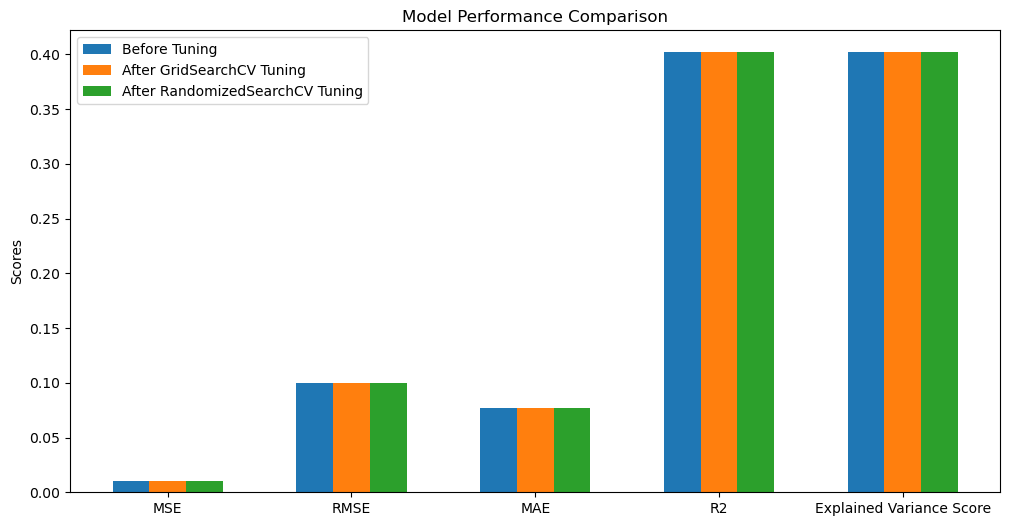

In [18]:


# Assuming l_mse, l_rmse, l_mae, l_r2, l_explained_variance are defined from the initial model run
# and mse, rmse, mae, r2, explained_variance are from the tuned model

metrics = ['MSE', 'RMSE', 'MAE', 'R2', 'Explained Variance Score']
values_before = [l_mse, l_rmse, l_mae, l_r2, l_explained_variance]
values_after_grid = [mse, rmse, mae, r2, explained_variance]
values_after_random = [mse_random, rmse_random, mae_random, r2_random, explained_variance_random]


x = range(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, values_before, width, label='Before Tuning')
rects2 = ax.bar([i + width for i in x], values_after_grid, width, label='After GridSearchCV Tuning')
rects3 = ax.bar([i + 2*width for i in x], values_after_random, width, label='After RandomizedSearchCV Tuning')


ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

### 2. Random Forest Regressor

In [19]:
model2=RandomForestRegressor()
model2.fit(x_train,y_train)

RandomForestRegressor()

In [20]:
y_predict2=model2.predict(x_test)

                               MSE      RMSE       MAE        R2  \
Random Forest Regressor   0.008565  0.092548  0.068549  0.481486   

                          Explained Variance Score:  
Random Forest Regressor                    0.481693  
-0.18480835763808445


<Axes: xlabel='O_3', ylabel='Density'>

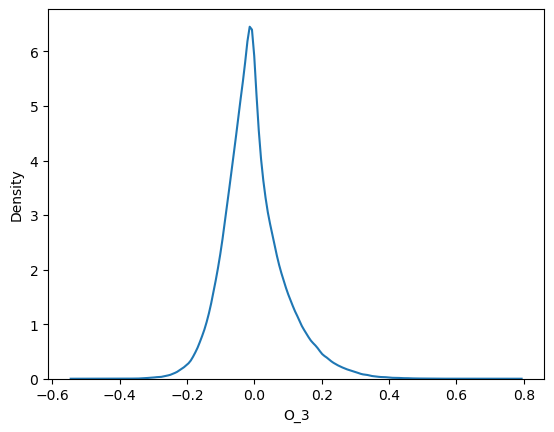

In [21]:
r_mse = mean_squared_error(y_test, y_predict2)
r_rmse = np.sqrt(r_mse)
r_mae = mean_absolute_error(y_test, y_predict2)
r_r2 = r2_score(y_test, y_predict2)
r_explained_variance = explained_variance_score(y_test, y_predict2)
print(pd.DataFrame({'MSE':r_mse,'RMSE':r_rmse,'MAE':r_mae,'R2':r_r2,'Explained Variance Score:':r_explained_variance},index=['Random Forest Regressor ']))
residue=y_test-y_predict2
print(residue.mean()*100)
sns.kdeplot(x=residue)


In [ ]:

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model2, param_grid=param_grid, cv=6, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Predict on the test set using the best model
y_pred = best_model.predict(x_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Display the results as a DataFrame
results_df = pd.DataFrame({
    'MSE': [mse],
    'RMSE': [rmse],
    'MAE': [mae],
    'R2': [r2],
    'Explained Variance Score': [explained_variance] 
}, index=['Tuned Random Forest'])
print(results_df)

# Residual analysis
residuals = y_test - y_pred
print("Mean of Residuals:", residuals.mean())

# Plot the residuals
sns.kdeplot(x=residuals, fill=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.show()

In [ ]:

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model2, param_distributions=param_dist, n_iter=1000, cv=7, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)

# Evaluate the best model on the test data
y_pred_random = best_model_random.predict(x_test)
mse_random = mean_squared_error(y_test, y_pred_random)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)
explained_variance_random = explained_variance_score(y_test, y_pred_random)

print(pd.DataFrame({'MSE':mse_random,'RMSE':rmse_random,'MAE':mae_random,'R2':r2_random,'Explained Variance Score:':explained_variance_random},index=['Tuned Linear Regression (RandomizedSearchCV)']))

residue_random = y_test - y_pred_random
print("Mean of residue (RandomizedSearchCV):", residue_random.mean())
sns.kdeplot(x=residue_random)
plt.show()

In [ ]:

metrics = ['MSE', 'RMSE', 'MAE', 'R2', 'Explained Variance Score']
values_before = [r_mse, r_rmse, r_mae, r_r2, r_explained_variance]
values_after_grid = [mse, rmse, mae, r2, explained_variance]
values_after_random = [mse_random, rmse_random, mae_random, r2_random, explained_variance_random]


x = range(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, values_before, width, label='Before Tuning')
rects2 = ax.bar([i + width for i in x], values_after_grid, width, label='After GridSearchCV Tuning')
rects3 = ax.bar([i + 2*width for i in x], values_after_random, width, label='After RandomizedSearchCV Tuning')


ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

###3. GradientBoostingRegressor

In [ ]:
model3= GradientBoostingRegressor()
model3.fit(x_train,y_train)

GradientBoostingRegressor()

In [22]:
y_predict3=model3.predict(x_test)

NameError: name 'model3' is not defined

In [ ]:
g_mse = mean_squared_error(y_test, y_predict3)
g_rmse = np.sqrt(g_mse)
g_mae = mean_absolute_error(y_test, y_predict3)
g_r2 = r2_score(y_test, y_predict3)
g_explained_variance = explained_variance_score(y_test, y_predict3)
print(pd.DataFrame({'MSE':g_mse,'RMSE':g_rmse,'MAE':g_mae,'R2':g_r2,'Explained Variance Score:':g_explained_variance},index=['GradientBoostingRegressor ']))
residue=y_test-y_predict3
print(residue.mean()*100)
sns.kdeplot(x=residue)

In [ ]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model3, param_grid=param_grid, cv=6, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test data
y_pred = best_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print(pd.DataFrame({'MSE':mse,'RMSE':rmse,'MAE':mae,'R2':r2,'Explained Variance Score:':explained_variance},index=['Tuned Linear Regression']))

residue = y_test - y_pred
print("Mean of residue:", residue.mean())
sns.kdeplot(x=residue)
plt.show()

In [ ]:

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model3, param_distributions=param_dist, n_iter=1000, cv=7, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)

# Evaluate the best model on the test data
y_pred_random = best_model_random.predict(x_test)
mse_random = mean_squared_error(y_test, y_pred_random)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)
explained_variance_random = explained_variance_score(y_test, y_pred_random)

print(pd.DataFrame({'MSE':mse_random,'RMSE':rmse_random,'MAE':mae_random,'R2':r2_random,'Explained Variance Score:':explained_variance_random},index=['Tuned Linear Regression (RandomizedSearchCV)']))

residue_random = y_test - y_pred_random
print("Mean of residue (RandomizedSearchCV):", residue_random.mean())
sns.kdeplot(x=residue_random)
plt.show()

In [ ]:

metrics = ['MSE', 'RMSE', 'MAE', 'R2', 'Explained Variance Score']
values_before = [g_mse,g_rmse, g_mae, g_r2, g_explained_variance]
values_after_grid = [mse, rmse, mae, r2, explained_variance]
values_after_random = [mse_random, rmse_random, mae_random, r2_random, explained_variance_random]


x = range(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, values_before, width, label='Before Tuning')
rects2 = ax.bar([i + width for i in x], values_after_grid, width, label='After GridSearchCV Tuning')
rects3 = ax.bar([i + 2*width for i in x], values_after_random, width, label='After RandomizedSearchCV Tuning')


ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

###4. DecisionTreeRegressor

In [ ]:
from sklearn import tree
model4=tree.DecisionTreeRegressor()
model4.fit(x_train,y_train)

DecisionTreeRegressor()

In [ ]:
y_predict4=model4.predict(x_test)

                               MSE      RMSE       MAE        R2  \
Decision Tree Regressor   0.015861  0.125939  0.088266  0.046573   

                          Explained Variance Score:  
Decision Tree Regressor                    0.046946  
-0.2492485734076589


<Axes: xlabel='O_3', ylabel='Density'>

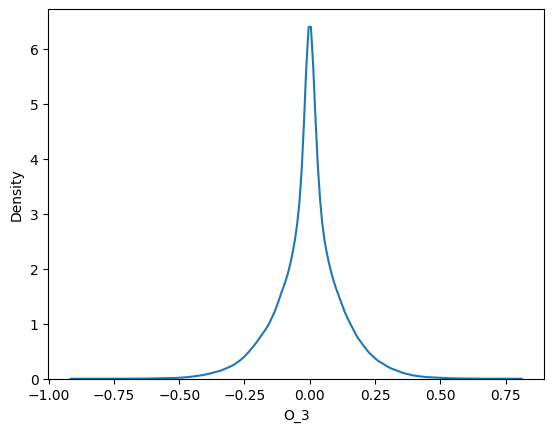

In [ ]:
dt_mse = mean_squared_error(y_test, y_predict4)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test, y_predict4)
dt_r2 = r2_score(y_test, y_predict4)
dt_explained_variance = explained_variance_score(y_test, y_predict4)
print(pd.DataFrame({'MSE':dt_mse,'RMSE':dt_rmse,'MAE':dt_mae,'R2':dt_r2,'Explained Variance Score:':dt_explained_variance},index=['Decision Tree Regressor ']))
residue=y_test-y_predict4
print(residue.mean()*100)
sns.kdeplot(x=residue)


In [ ]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model4, param_grid=param_grid, cv=6, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test data
y_pred = best_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print(pd.DataFrame({'MSE':mse,'RMSE':rmse,'MAE':mae,'R2':r2,'Explained Variance Score:':explained_variance},index=['Tuned Linear Regression']))

residue = y_test - y_pred
print("Mean of residue:", residue.mean())
sns.kdeplot(x=residue)
plt.show()

In [ ]:

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model4, param_distributions=param_dist, n_iter=1000, cv=7, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)

# Evaluate the best model on the test data
y_pred_random = best_model_random.predict(x_test)
mse_random = mean_squared_error(y_test, y_pred_random)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)
explained_variance_random = explained_variance_score(y_test, y_pred_random)

print(pd.DataFrame({'MSE':mse_random,'RMSE':rmse_random,'MAE':mae_random,'R2':r2_random,'Explained Variance Score:':explained_variance_random},index=['Tuned Linear Regression (RandomizedSearchCV)']))

residue_random = y_test - y_pred_random
print("Mean of residue (RandomizedSearchCV):", residue_random.mean())
sns.kdeplot(x=residue_random)
plt.show()

In [ ]:

metrics = ['MSE', 'RMSE', 'MAE', 'R2', 'Explained Variance Score']
values_before = [dt_mse,dt_rmse, dt_mae, dt_r2, dt_explained_variance]
values_after_grid = [mse, rmse, mae, r2, explained_variance]
values_after_random = [mse_random, rmse_random, mae_random, r2_random, explained_variance_random]


x = range(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, values_before, width, label='Before Tuning')
rects2 = ax.bar([i + width for i in x], values_after_grid, width, label='After GridSearchCV Tuning')
rects3 = ax.bar([i + 2*width for i in x], values_after_random, width, label='After RandomizedSearchCV Tuning')


ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

###5. Ridge Regressor

In [ ]:
model5=Ridge(alpha=0.1)
model5.fit(x_train,y_train)


Ridge(alpha=0.1)

In [ ]:
y_predict5=model5.predict(x_test)

                      MSE      RMSE       MAE        R2  \
Ridge Regressor   0.00981  0.099047  0.076255  0.410273   

                  Explained Variance Score:  
Ridge Regressor                    0.410277  
-0.025880361391150707


<Axes: xlabel='O_3', ylabel='Density'>

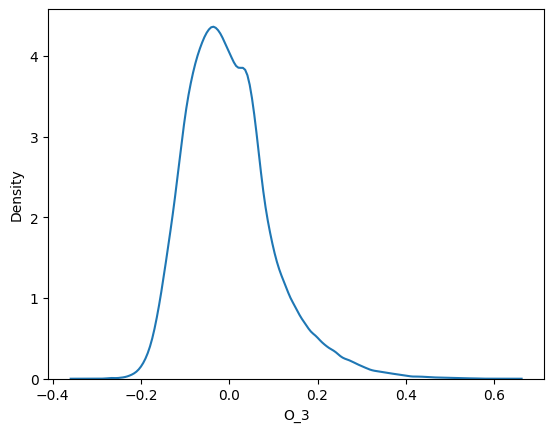

In [ ]:
et_mse = mean_squared_error(y_test, y_predict5)
et_rmse = np.sqrt(et_mse)
et_mae = mean_absolute_error(y_test, y_predict5)
et_r2 = r2_score(y_test, y_predict5)
et_explained_variance = explained_variance_score(y_test, y_predict5)
print(pd.DataFrame({'MSE':et_mse,'RMSE':et_rmse,'MAE':et_mae,'R2':et_r2,'Explained Variance Score:':et_explained_variance},index=['Ridge Regressor ']))
residue=y_test-y_predict5
print(residue.mean()*100)
sns.kdeplot(x=residue)

In [ ]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model5, param_grid=param_grid, cv=6, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test data
y_pred = best_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print(pd.DataFrame({'MSE':mse,'RMSE':rmse,'MAE':mae,'R2':r2,'Explained Variance Score:':explained_variance},index=['Tuned Linear Regression']))

residue = y_test - y_pred
print("Mean of residue:", residue.mean())
sns.kdeplot(x=residue)
plt.show()

In [ ]:

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model5, param_distributions=param_dist, n_iter=1000, cv=7, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)

# Evaluate the best model on the test data
y_pred_random = best_model_random.predict(x_test)
mse_random = mean_squared_error(y_test, y_pred_random)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)
explained_variance_random = explained_variance_score(y_test, y_pred_random)

print(pd.DataFrame({'MSE':mse_random,'RMSE':rmse_random,'MAE':mae_random,'R2':r2_random,'Explained Variance Score:':explained_variance_random},index=['Tuned Linear Regression (RandomizedSearchCV)']))

residue_random = y_test - y_pred_random
print("Mean of residue (RandomizedSearchCV):", residue_random.mean())
sns.kdeplot(x=residue_random)
plt.show()

In [ ]:

metrics = ['MSE', 'RMSE', 'MAE', 'R2', 'Explained Variance Score']
values_before = [et_mse,et_rmse, et_mae, et_r2, et_explained_variance]
values_after_grid = [mse, rmse, mae, r2, explained_variance]
values_after_random = [mse_random, rmse_random, mae_random, r2_random, explained_variance_random]


x = range(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, values_before, width, label='Before Tuning')
rects2 = ax.bar([i + width for i in x], values_after_grid, width, label='After GridSearchCV Tuning')
rects3 = ax.bar([i + 2*width for i in x], values_after_random, width, label='After RandomizedSearchCV Tuning')


ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

#Performance Comparison

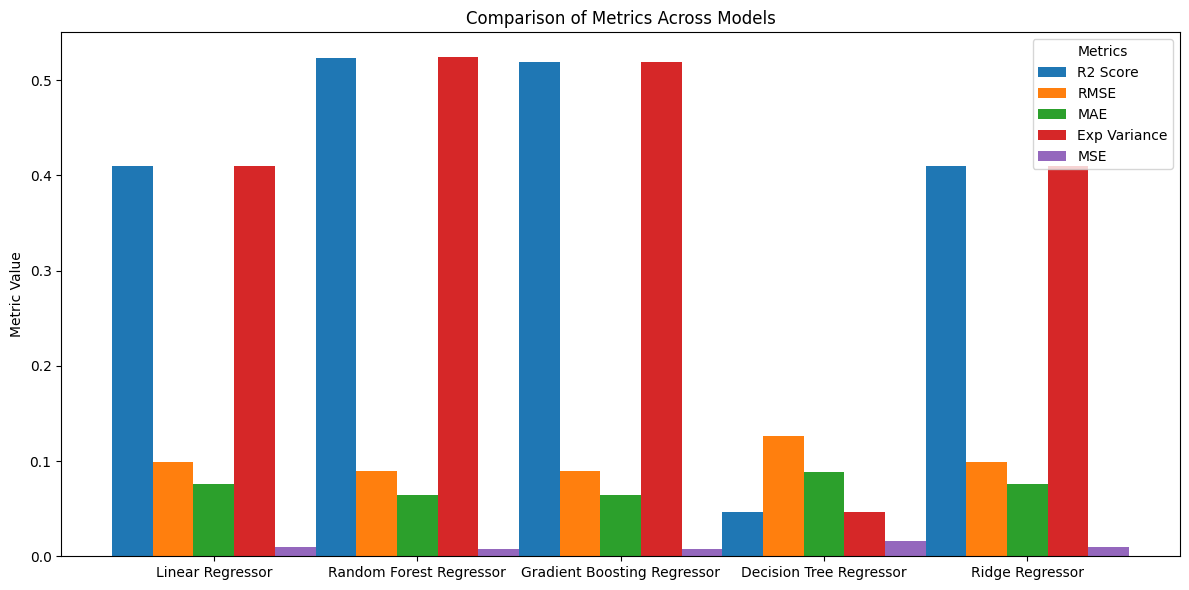

In [ ]:
metrics = ["R2 Score", "RMSE", "MAE","Exp Variance",'MSE']
model_names = ["Linear Regressor", "Random Forest Regressor", "Gradient Boosting Regressor",'Decision Tree Regressor','Ridge Regressor']

# Example metric values (rows: metrics, columns: models)
metric_values = np.array([
    [l_r2, r_r2, g_r2,dt_r2,et_r2],
    [l_rmse, r_rmse, g_rmse,dt_rmse,et_rmse],
    [l_mae, r_mae, g_mae,dt_mae,et_mae],
    [l_explained_variance, r_explained_variance,g_explained_variance,dt_explained_variance,et_explained_variance],
    [l_mse, r_mse,g_mse,dt_mse,et_mse],

])

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(model_names))

bar_width = 0.2
for i, metric in enumerate(metrics):
    ax.bar(x + i * bar_width, metric_values[i], width=bar_width, label=metric)

ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(model_names)
ax.set_ylabel("Metric Value")
ax.set_title("Comparison of Metrics Across Models")
ax.legend(title="Metrics")
plt.tight_layout()
plt.show()